# Telecom churn predictions
----
As part of the Maven Analytics Challenge (https://www.mavenanalytics.io/blog/maven-churn-challenge), this project concerns the prediction of 'Customer Status' among three choices: churned, stayed and joined. A dataset containing information on 7043 customers from a Telecommunications company in California has been used. Each record contains details about the demographics, location, tenure, subscription services and more (38 features in total) for each customer. 

Several models have been trained on the dataset which was subjected to various data engineering techniques. At the end a comparison of the scores provided by each model have been showed and analyzed. 

The present notebook is organized as follows:

1. **EDA**: Numerical analysis and Categorical analysis
2. **Modeling**: Logistic Regression and Feature engineering
3. **Handling Data Imbalance**
4. **Testing other models**: SVC, Random Forest and Gradient Boosting
5. **Model Comparison and Final Remarks**


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api 
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from statsmodels.formula.api import ols
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score,StratifiedKFold,learning_curve
from sklearn.metrics import classification_report,f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telecom-customer-churn-by-maven-analytics/telecom_customer_churn.csv
/kaggle/input/telecom-customer-churn-by-maven-analytics/telecom_zipcode_population.csv
/kaggle/input/telecom-customer-churn-by-maven-analytics/telecom_data_dictionary.csv


In [2]:
# --- Functions ---


# Plot learning curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt



In [3]:
df = pd.read_csv(r'/kaggle/input/telecom-customer-churn-by-maven-analytics/telecom_customer_churn.csv')
df.head()

,Customer ID,Gender,Age,Married,Number of Dependents,City,Zip Code,Latitude,Longitude,Number of Referrals,...,Payment Method,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Customer Status,Churn Category,Churn Reason
0,0002-ORFBO,Female,37,Yes,0,Frazier Park,93225,34.827662,-118.999073,2,...,Credit Card,65.6,593.30,0.00,0,381.51,974.81,Stayed,NaN,NaN
1,0003-MKNFE,Male,46,No,0,Glendale,91206,34.162515,-118.203869,0,...,Credit Card,-4.0,542.40,38.33,10,96.21,610.28,Stayed,NaN,NaN
2,0004-TLHLJ,Male,50,No,0,Costa Mesa,92627,33.645672,-117.922613,0,...,Bank Withdrawal,73.9,280.85,0.00,0,134.60,415.45,Churned,Competitor,Competitor had better devices
3,0011-IGKFF,Male,78,Yes,0,Martinez,94553,38.014457,-122.115432,1,...,Bank Withdrawal,98.0,1237.85,0.00,0,361.66,1599.51,Churned,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,Female,75,Yes,0,Camarillo,93010,34.227846,-119.079903,3,...,Credit Card,83.9,267.40,0.00,0,22.14,289.54,Churned,Dissatisfaction,Network reliability


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              7043 non-null   objec

Let's drop the textual "Churn reason" and "Churn Category" having too many Nan values


In [5]:
df = df.drop(['Churn Category','Churn Reason','Customer ID'],axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Age                                7043 non-null   int64  
 2   Married                            7043 non-null   object 
 3   Number of Dependents               7043 non-null   int64  
 4   City                               7043 non-null   object 
 5   Zip Code                           7043 non-null   int64  
 6   Latitude                           7043 non-null   float64
 7   Longitude                          7043 non-null   float64
 8   Number of Referrals                7043 non-null   int64  
 9   Tenure in Months                   7043 non-null   int64  
 10  Offer                              7043 non-null   object 
 11  Phone Service                      7043 non-null   objec

In [7]:
df['Zip Code']=df['Zip Code'].astype('object')

In [8]:
df.duplicated().any()

False

In [9]:
df_num = df.select_dtypes('number')
df_object = df.select_dtypes('object')

# EDA
---
## Numerical analyis

In [10]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                7043 non-null   int64  
 1   Number of Dependents               7043 non-null   int64  
 2   Latitude                           7043 non-null   float64
 3   Longitude                          7043 non-null   float64
 4   Number of Referrals                7043 non-null   int64  
 5   Tenure in Months                   7043 non-null   int64  
 6   Avg Monthly Long Distance Charges  6361 non-null   float64
 7   Avg Monthly GB Download            5517 non-null   float64
 8   Monthly Charge                     7043 non-null   float64
 9   Total Charges                      7043 non-null   float64
 10  Total Refunds                      7043 non-null   float64
 11  Total Extra Data Charges           7043 non-null   int64

In [11]:
df_num.describe()

,Age,Number of Dependents,Latitude,Longitude,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,6361.000000,5517.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,36.197455,-119.756684,1.951867,32.386767,25.420517,26.189958,63.596131,2280.381264,1.962182,6.860713,749.099262,3034.379056
std,16.750352,0.962802,2.468929,2.154425,3.001199,24.542061,14.200374,19.586585,31.204743,2266.220462,7.902614,25.104978,846.660055,2865.204542
min,19.000000,0.000000,32.555828,-124.301372,0.000000,1.000000,1.010000,2.000000,-10.000000,18.800000,0.000000,0.000000,0.000000,21.360000
25%,32.000000,0.000000,33.990646,-121.788090,0.000000,9.000000,13.050000,13.000000,30.400000,400.150000,0.000000,0.000000,70.545000,605.610000
50%,46.000000,0.000000,36.205465,-119.595293,0.000000,29.000000,25.690000,21.000000,70.050000,1394.550000,0.000000,0.000000,401.440000,2108.640000
75%,60.000000,0.000000,38.161321,-117.969795,3.000000,55.000000,37.680000,30.000000,89.750000,3786.600000,0.000000,0.000000,1191.100000,4801.145000
max,80.000000,9.000000,41.962127,-114.192901,11.000000,72.000000,49.990000,85.000000,118.750000,8684.800000,49.790000,150.000000,3564.720000,11979.340000


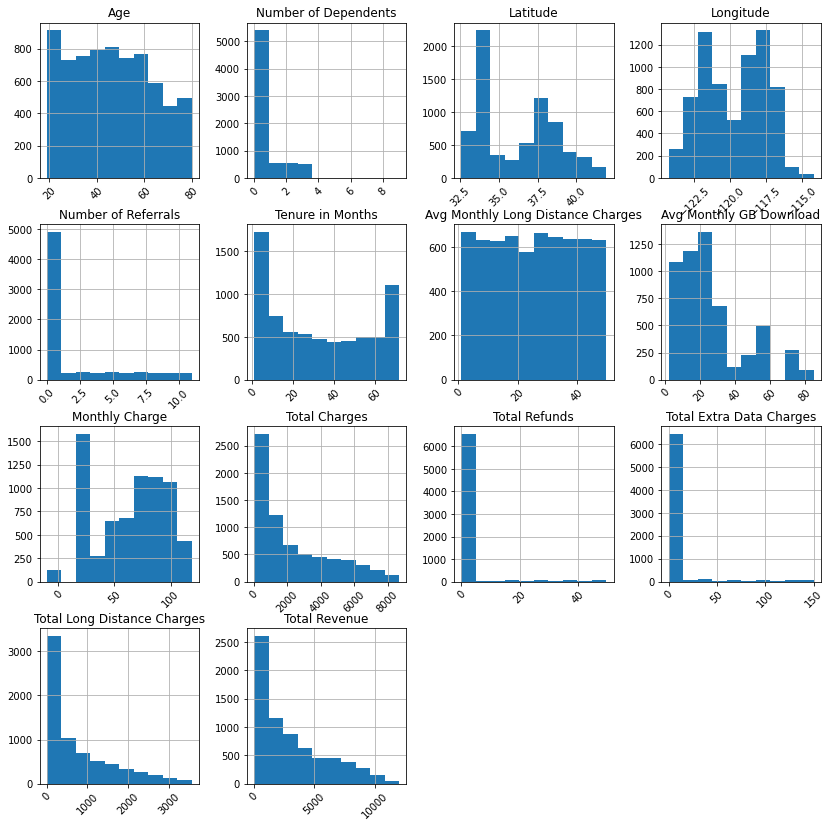

In [12]:
df_num.hist(figsize=(14,14), xrot=45);


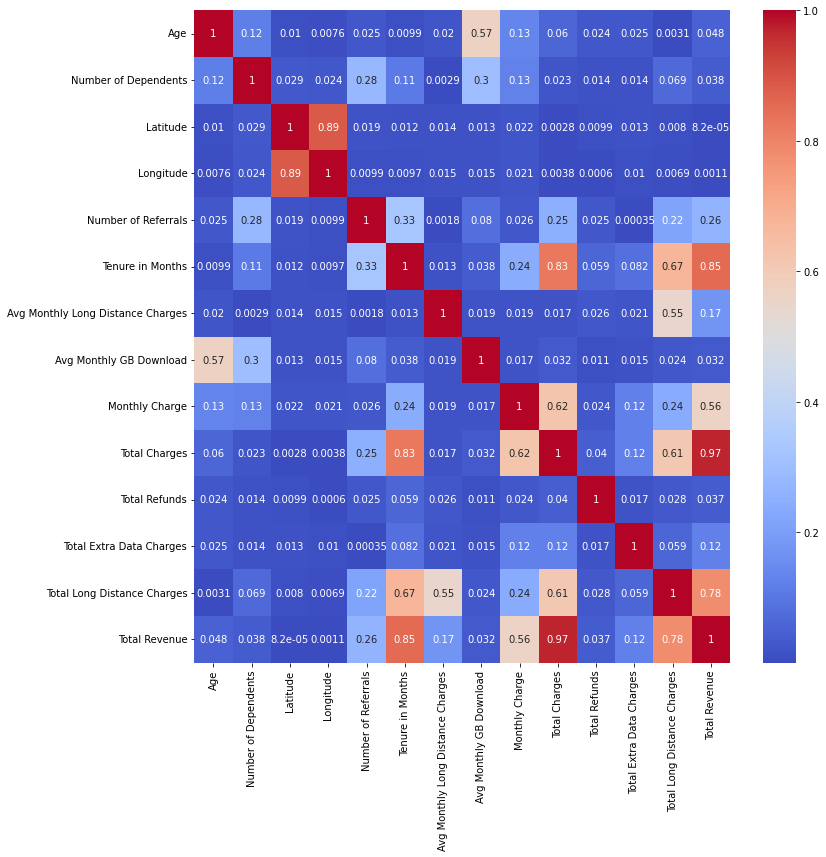

In [13]:
cor = df_num.join(df_object['Customer Status']).corr().abs()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor, annot=True, ax = ax, cmap='coolwarm');

In [14]:
s = cor.unstack()
so = s.replace(1,0).sort_values(kind="quicksort",ascending=False)[:20]
print(so)

Total Charges                Total Revenue                  0.972212
Total Revenue                Total Charges                  0.972212
Latitude                     Longitude                      0.885979
Longitude                    Latitude                       0.885979
Total Revenue                Tenure in Months               0.853146
Tenure in Months             Total Revenue                  0.853146
Total Charges                Tenure in Months               0.826074
Tenure in Months             Total Charges                  0.826074
Total Long Distance Charges  Total Revenue                  0.778559
Total Revenue                Total Long Distance Charges    0.778559
Total Long Distance Charges  Tenure in Months               0.674149
Tenure in Months             Total Long Distance Charges    0.674149
Total Charges                Monthly Charge                 0.622810
Monthly Charge               Total Charges                  0.622810
Total Long Distance Charges  Total

In [15]:
print('Number of unique categories in Zip Code: %i'% df['Zip Code'].nunique())
print('Number of unique categories in City: %i'% df['City'].nunique())

Number of unique categories in Zip Code: 1626
Number of unique categories in City: 1106


 ##### COMMENTS: 
* Total Revenue: Indicates the company's total revenue from this customer, 
 calculated to the end of the quarter specified above (Total Charges - Total Refunds + Total Extra Data Charges + Total Long Distance Charges)
* Total Charges: Indicates the customer's total charges, calculated to the end of the quarter specified above
* Tenure in Months: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above
* Total Long Distance Charges: Indicates the customer's total charges for long distance above those specified in their plan, by the end of the quarter specified above
* Monthly charges: Indicates the customer's current total monthly charge for all their services from the company

Based on the correlation maps we can drop **Total Charges** and **Total Long Distance Charges** being highly correlated with **Total Revenue **

Also City, ZipCode, latitude and longitude can be dropped from the dataset being too personal and specific to be useful in the training step. Moreover for each category we have too few example to be meanigful

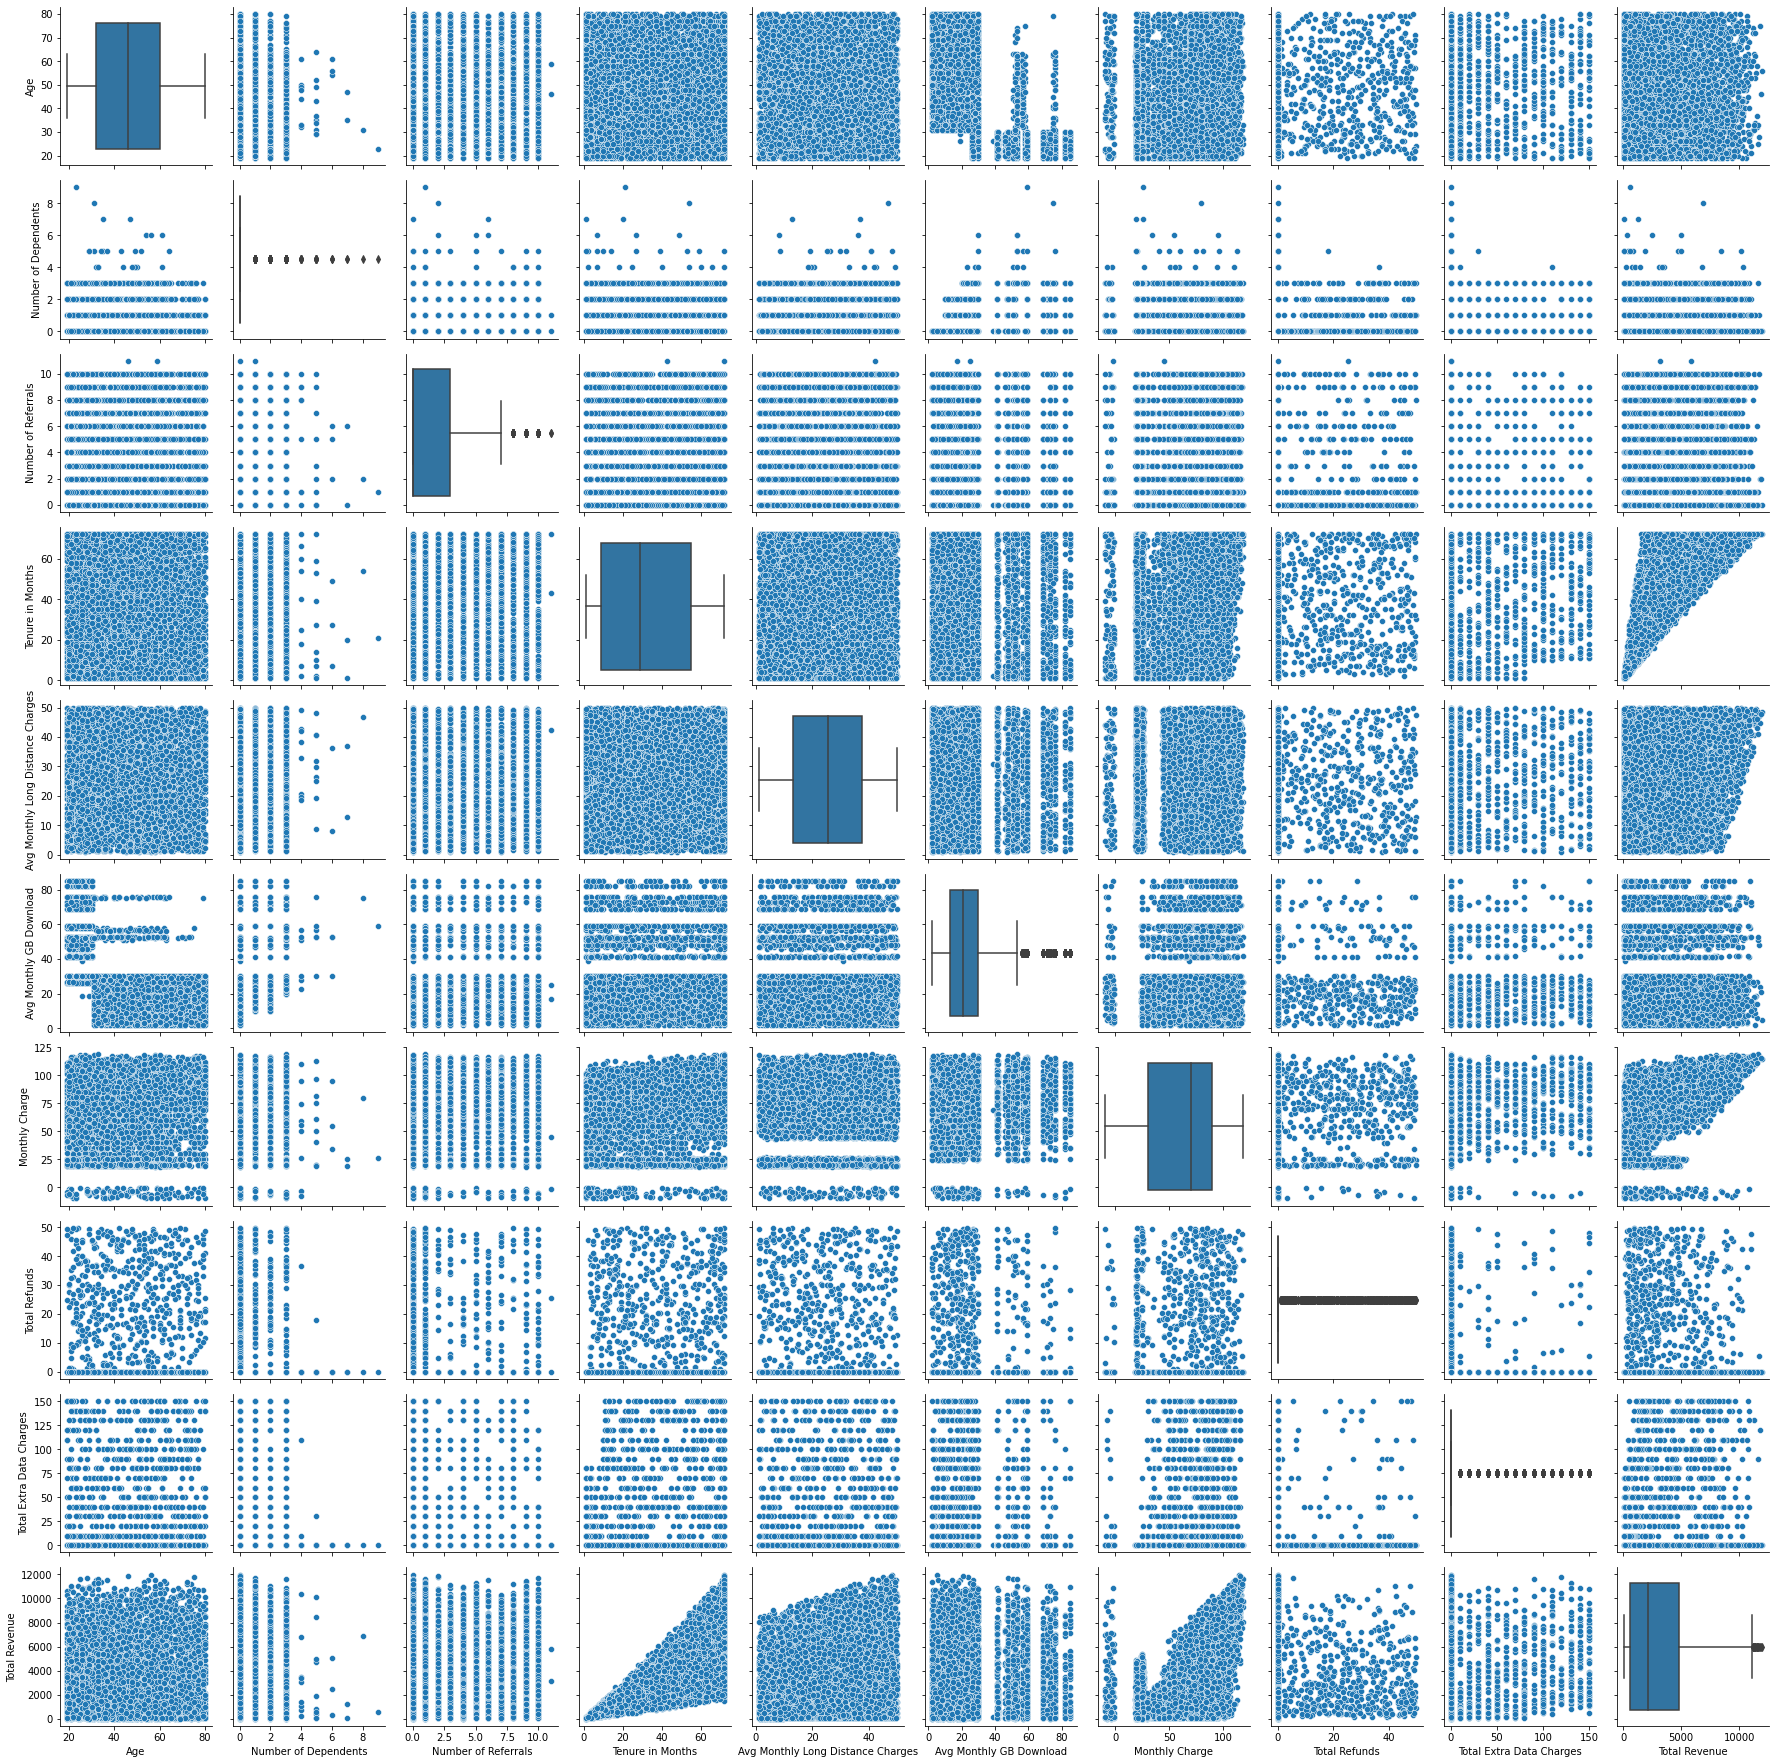

In [16]:
df_num = df_num.drop(['Total Charges','Total Long Distance Charges','Longitude','Latitude'],axis=1)
p = sns.PairGrid(df_num);
p.map_diag(sns.boxplot)
p.map_offdiag(sns.scatterplot)


- The scatter plot does not show any further correlation between the continuous variables.
- The Boxplots shows that the features 'Avg Monthly GB Download', 'Total Refunds', 'Number of Dependents', 'Number of Referrals' and 'Total Extra Data Charges' need to be further analysed


**Avg Monthly GB Download**:

<AxesSubplot:>

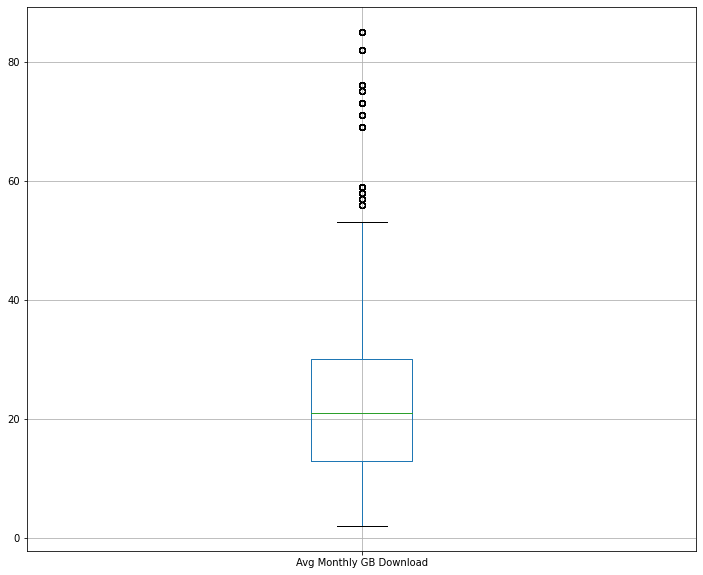

In [17]:
df_num[['Avg Monthly GB Download']].boxplot(figsize=(12,10))

#### We need to analyze if the outliers that we see in the graph above are meaningful or not. To do so, we have to look for the reason of such high downloading
Let's see if the age has an influence

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


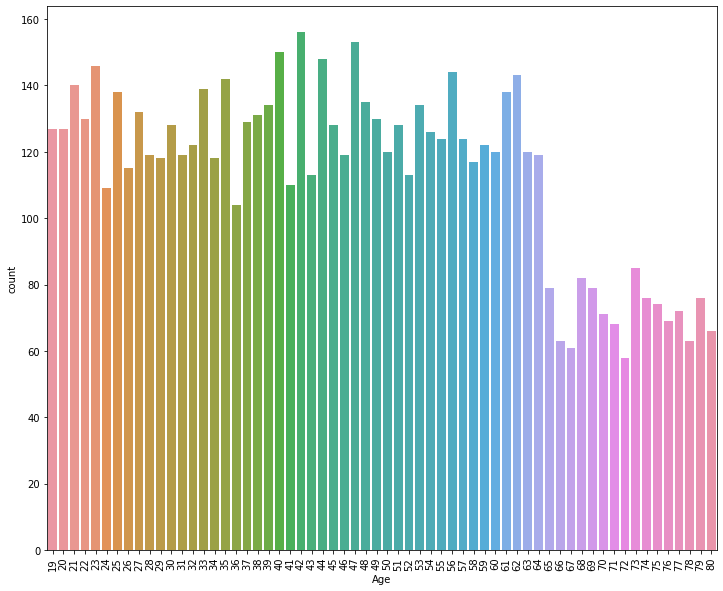

In [18]:
plt.figure(figsize=(12,10))
sns.countplot(df['Age'])
plt.xticks(rotation=90);

#### Let's organize the datasets in age buckets and see the distribution of the variable 'Avg Monthly GB Download' based on the Age group

In [19]:
bins = [19,30,45,60,80]
names = ['19-30','30-45','45-60','60-80']
df_object['AgeRange'] = pd.cut(df['Age'],bins, labels=names,include_lowest=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 1152x1008 with 0 Axes>

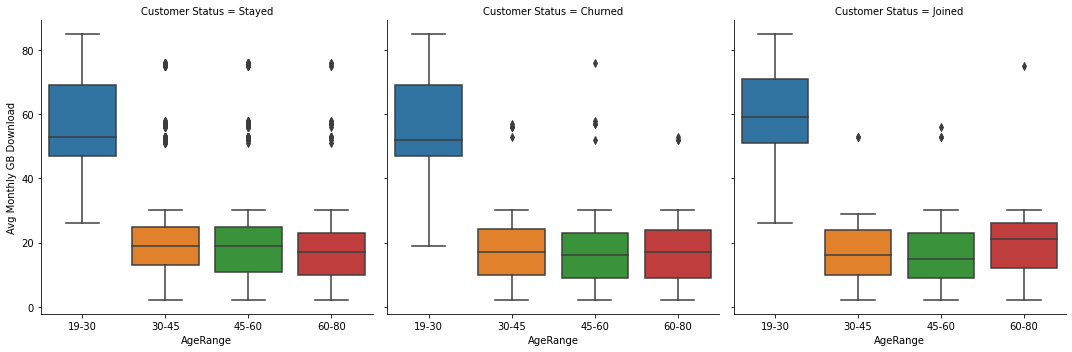

In [20]:
plt.figure(figsize=(16,14))
sns.catplot(data=df_object.join(df_num),x='AgeRange',y='Avg Monthly GB Download', col ='Customer Status',kind='box')

#### As expected younger people have by far the highest download flow than the other age groups. 

**Total Extra Data Charges, Number of Dependents, Total Refunds and Number of Referrals:**

Unique values population 

In [21]:
pd.concat([df['Total Extra Data Charges'].value_counts(normalize=True).reset_index(),df['Number of Dependents'].value_counts(normalize=True).reset_index(),
          df['Total Refunds'].value_counts(normalize=True).reset_index(),df['Number of Referrals'].value_counts(normalize=True).reset_index()],axis=1).rename(columns={'index':'value'})

,value,Total Extra Data Charges,value,Number of Dependents,value,Total Refunds,value,Number of Referrals
0,0.0,0.896635,0.0,0.768990,0.00,0.925458,0.0,0.542524
1,10.0,0.019594,1.0,0.078518,16.56,0.000284,1.0,0.154196
2,40.0,0.008803,2.0,0.075394,8.74,0.000284,5.0,0.037484
3,30.0,0.008235,3.0,0.073406,1.31,0.000284,3.0,0.036206
4,20.0,0.007241,5.0,0.001420,41.74,0.000284,7.0,0.035212
...,...,...,...,...,...,...,...,...
495,NaN,NaN,NaN,NaN,31.90,0.000142,NaN,NaN
496,NaN,NaN,NaN,NaN,12.07,0.000142,NaN,NaN
497,NaN,NaN,NaN,NaN,37.37,0.000142,NaN,NaN
498,NaN,NaN,NaN,NaN,48.59,0.000142,NaN,NaN


#### 'Total Refunds', 'Number of Dependents', 'Number of Referrals' and 'Total Extra Data Charges' are mostly populated by zero values therefore they could be transformed into a binary categorical variable

In [22]:
df_object.loc[:,'Refunds_cat'] = np.where(df['Total Refunds'] == 0,'NO','YES')
df_object.loc[:,'Dependents_cat'] = np.where(df['Number of Dependents'] == 0,'NO','YES')
df_object.loc[:,'Extra_Data_Charges_cat'] = np.where(df['Total Extra Data Charges'] == 0,'NO','YES')
df_object.loc[:,'Referrals_cat'] = np.where(df['Number of Referrals'] == 0, 'NO', 'Yes')

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Numeric features vs target (Customer Status)

In [23]:
df_num.columns

Index(['Age', 'Number of Dependents', 'Number of Referrals',
       'Tenure in Months', 'Avg Monthly Long Distance Charges',
       'Avg Monthly GB Download', 'Monthly Charge', 'Total Refunds',
       'Total Extra Data Charges', 'Total Revenue'],
      dtype='object')

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/boxplot.py:405: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


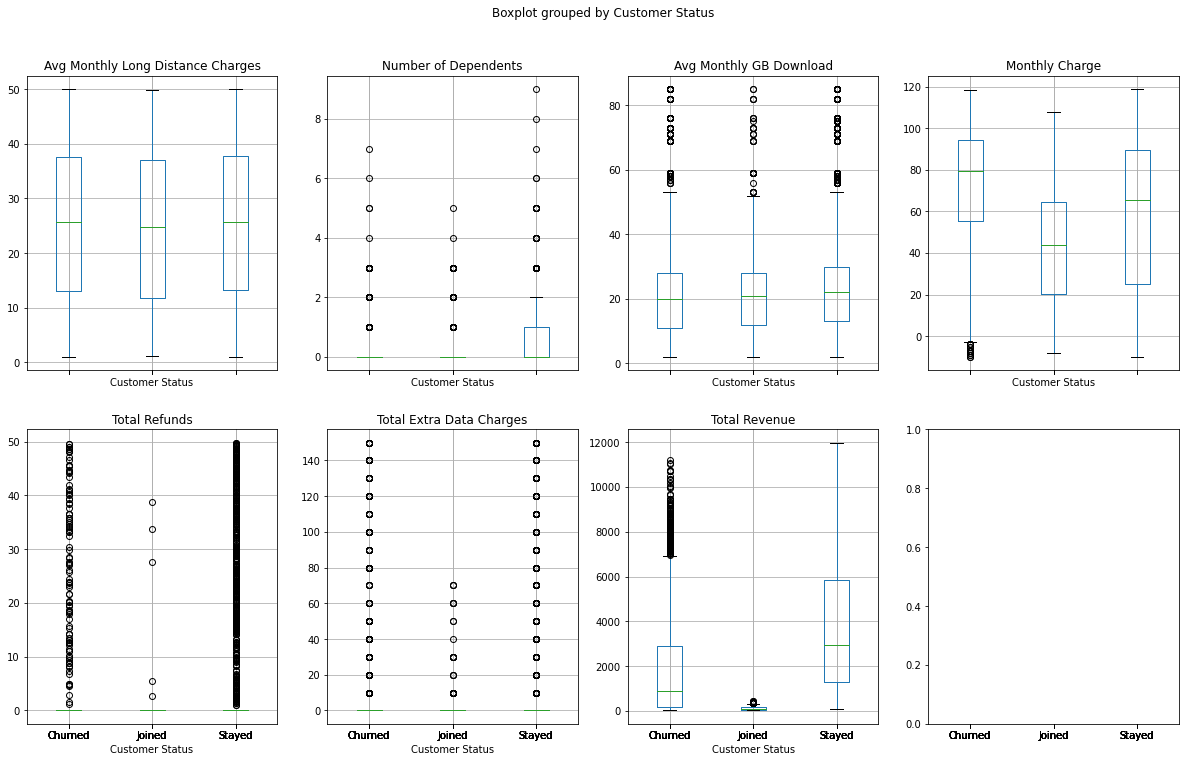

In [24]:
fig, axes = plt.subplots(2,4,sharex=True,sharey=False,figsize=(20,12))
df_num.join(df['Customer Status']).boxplot(['Avg Monthly Long Distance Charges','Number of Dependents','Avg Monthly GB Download','Monthly Charge','Total Refunds','Total Extra Data Charges','Total Revenue'],'Customer Status',ax=axes.flatten()[:-1]);

#### People who churned have on average higher monthly charges 

<Figure size 864x720 with 0 Axes>

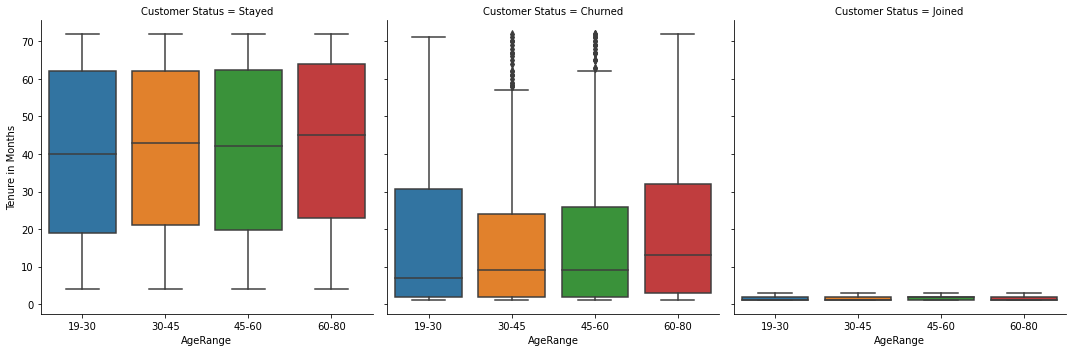

In [25]:
plt.figure(figsize=(12,10))
sns.catplot(data=df_object.join(df_num),x='AgeRange',y='Tenure in Months',kind='box',col='Customer Status')

>#### In general, after thirty months the customer tends to remain loyal to the company 
It could be useful to create another binary variable depending on whether the customer is loyal (Tenure > 30) or not.


In [26]:
df_object.loc[:,'is_loyal'] = np.where(df['Tenure in Months'] >= 30, 'Yes','No')

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


## Categorical analysis

In [27]:
df_object = df_object.drop(['City','Zip Code'],axis=1)

In [28]:
for col in df_object.columns:
    print('Feature "%s" has %i unique values'%(col, df_object[col].nunique()))
    

Feature "Gender" has 2 unique values
Feature "Married" has 2 unique values
Feature "Offer" has 6 unique values
Feature "Phone Service" has 2 unique values
Feature "Multiple Lines" has 2 unique values
Feature "Internet Service" has 2 unique values
Feature "Internet Type" has 3 unique values
Feature "Online Security" has 2 unique values
Feature "Online Backup" has 2 unique values
Feature "Device Protection Plan" has 2 unique values
Feature "Premium Tech Support" has 2 unique values
Feature "Streaming TV" has 2 unique values
Feature "Streaming Movies" has 2 unique values
Feature "Streaming Music" has 2 unique values
Feature "Unlimited Data" has 2 unique values
Feature "Contract" has 3 unique values
Feature "Paperless Billing" has 2 unique values
Feature "Payment Method" has 3 unique values
Feature "Customer Status" has 3 unique values
Feature "AgeRange" has 4 unique values
Feature "Refunds_cat" has 2 unique values
Feature "Dependents_cat" has 2 unique values
Feature "Extra_Data_Charges_ca

In [29]:
df_object.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Gender                  7043 non-null   object  
 1   Married                 7043 non-null   object  
 2   Offer                   7043 non-null   object  
 3   Phone Service           7043 non-null   object  
 4   Multiple Lines          6361 non-null   object  
 5   Internet Service        7043 non-null   object  
 6   Internet Type           5517 non-null   object  
 7   Online Security         5517 non-null   object  
 8   Online Backup           5517 non-null   object  
 9   Device Protection Plan  5517 non-null   object  
 10  Premium Tech Support    5517 non-null   object  
 11  Streaming TV            5517 non-null   object  
 12  Streaming Movies        5517 non-null   object  
 13  Streaming Music         5517 non-null   object  
 14  Unlimited Data          

```The variables implying internet connection (Internet Type, Online Security, Online Backup, Device Protection Plan, Premium Tech Support, Streaming, Unlimited Data, Avg Monthly GB Download) have the same number of nan values. According to the description these are not missing values but indicates no subscrition to the internet service by the customer. ```

**Example**

In [30]:
df_object['Internet Service'].value_counts()

Yes    5517
No     1526
Name: Internet Service, dtype: int64

In [31]:
df_object.join(df_num)[['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 
           'Premium Tech Support', 'Streaming TV', 'Streaming Movies','Streaming Music','Unlimited Data','Avg Monthly GB Download']].isna().sum()

Internet Type              1526
Online Security            1526
Online Backup              1526
Device Protection Plan     1526
Premium Tech Support       1526
Streaming TV               1526
Streaming Movies           1526
Streaming Music            1526
Unlimited Data             1526
Avg Monthly GB Download    1526
dtype: int64

```The number of Nan values is equal to number of NO values in 'Internet Service' thereby suggesting that Nan are not missing values```

In [32]:
df_object[['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 
           'Premium Tech Support', 'Streaming TV', 'Streaming Movies','Streaming Music','Unlimited Data']] = df_object[['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 
           'Premium Tech Support', 'Streaming TV', 'Streaming Movies','Streaming Music','Unlimited Data']].replace(np.nan,'No Internet')
df_num['Avg Monthly GB Download'] = df_num['Avg Monthly GB Download'].replace(np.nan,0.0)

In [33]:
df_object.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Gender                  7043 non-null   object  
 1   Married                 7043 non-null   object  
 2   Offer                   7043 non-null   object  
 3   Phone Service           7043 non-null   object  
 4   Multiple Lines          6361 non-null   object  
 5   Internet Service        7043 non-null   object  
 6   Internet Type           7043 non-null   object  
 7   Online Security         7043 non-null   object  
 8   Online Backup           7043 non-null   object  
 9   Device Protection Plan  7043 non-null   object  
 10  Premium Tech Support    7043 non-null   object  
 11  Streaming TV            7043 non-null   object  
 12  Streaming Movies        7043 non-null   object  
 13  Streaming Music         7043 non-null   object  
 14  Unlimited Data          

In [34]:
df_object['Phone Service'].value_counts()

Yes    6361
No      682
Name: Phone Service, dtype: int64

In [35]:
df_object['Multiple Lines'].isna().sum()

682

In [36]:
df_num['Avg Monthly Long Distance Charges'].isna().sum()

682

In [37]:
df_object[df_object['Multiple Lines'].isna()]

,Gender,Married,Offer,Phone Service,Multiple Lines,Internet Service,Internet Type,Online Security,Online Backup,Device Protection Plan,...,Contract,Paperless Billing,Payment Method,Customer Status,AgeRange,Refunds_cat,Dependents_cat,Extra_Data_Charges_cat,Referrals_cat,is_loyal
10,Male,No,None,No,NaN,Yes,Cable,Yes,No,No,...,Two Year,No,Credit Card,Stayed,45-60,NO,NO,NO,NO,Yes
14,Female,No,None,No,NaN,Yes,DSL,Yes,Yes,Yes,...,Two Year,No,Bank Withdrawal,Stayed,30-45,NO,NO,NO,NO,Yes
16,Female,Yes,None,No,NaN,Yes,DSL,Yes,No,Yes,...,One Year,No,Credit Card,Stayed,45-60,NO,YES,NO,NO,Yes
19,Male,No,None,No,NaN,Yes,Cable,No,No,No,...,Month-to-Month,Yes,Bank Withdrawal,Churned,60-80,NO,NO,NO,NO,No
25,Female,Yes,None,No,NaN,Yes,DSL,Yes,No,No,...,Month-to-Month,No,Bank Withdrawal,Churned,30-45,NO,YES,NO,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6979,Female,No,Offer B,No,NaN,Yes,Cable,No,Yes,Yes,...,Two Year,Yes,Bank Withdrawal,Stayed,60-80,NO,NO,NO,NO,Yes
6980,Female,No,Offer E,No,NaN,Yes,DSL,No,No,No,...,Month-to-Month,No,Credit Card,Churned,60-80,NO,NO,NO,NO,No
6996,Female,No,Offer D,No,NaN,Yes,DSL,Yes,No,Yes,...,Two Year,No,Credit Card,Stayed,45-60,NO,NO,NO,NO,No
7016,Male,Yes,None,No,NaN,Yes,DSL,No,Yes,Yes,...,One Year,Yes,Credit Card,Stayed,19-30,NO,NO,NO,Yes,Yes


#### Nan values associated to the variable 'Multiple Lines' are due to the fact that the customer is not subscribed to home phone service

In [38]:
df_object['Multiple Lines'] = df_object['Multiple Lines'].replace(np.nan,'NO phone Service')
df_num['Avg Monthly Long Distance Charges'] = df_num['Avg Monthly Long Distance Charges'].replace(np.nan,'NO phone Service')


In [39]:
df_object.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Gender                  7043 non-null   object  
 1   Married                 7043 non-null   object  
 2   Offer                   7043 non-null   object  
 3   Phone Service           7043 non-null   object  
 4   Multiple Lines          7043 non-null   object  
 5   Internet Service        7043 non-null   object  
 6   Internet Type           7043 non-null   object  
 7   Online Security         7043 non-null   object  
 8   Online Backup           7043 non-null   object  
 9   Device Protection Plan  7043 non-null   object  
 10  Premium Tech Support    7043 non-null   object  
 11  Streaming TV            7043 non-null   object  
 12  Streaming Movies        7043 non-null   object  
 13  Streaming Music         7043 non-null   object  
 14  Unlimited Data          

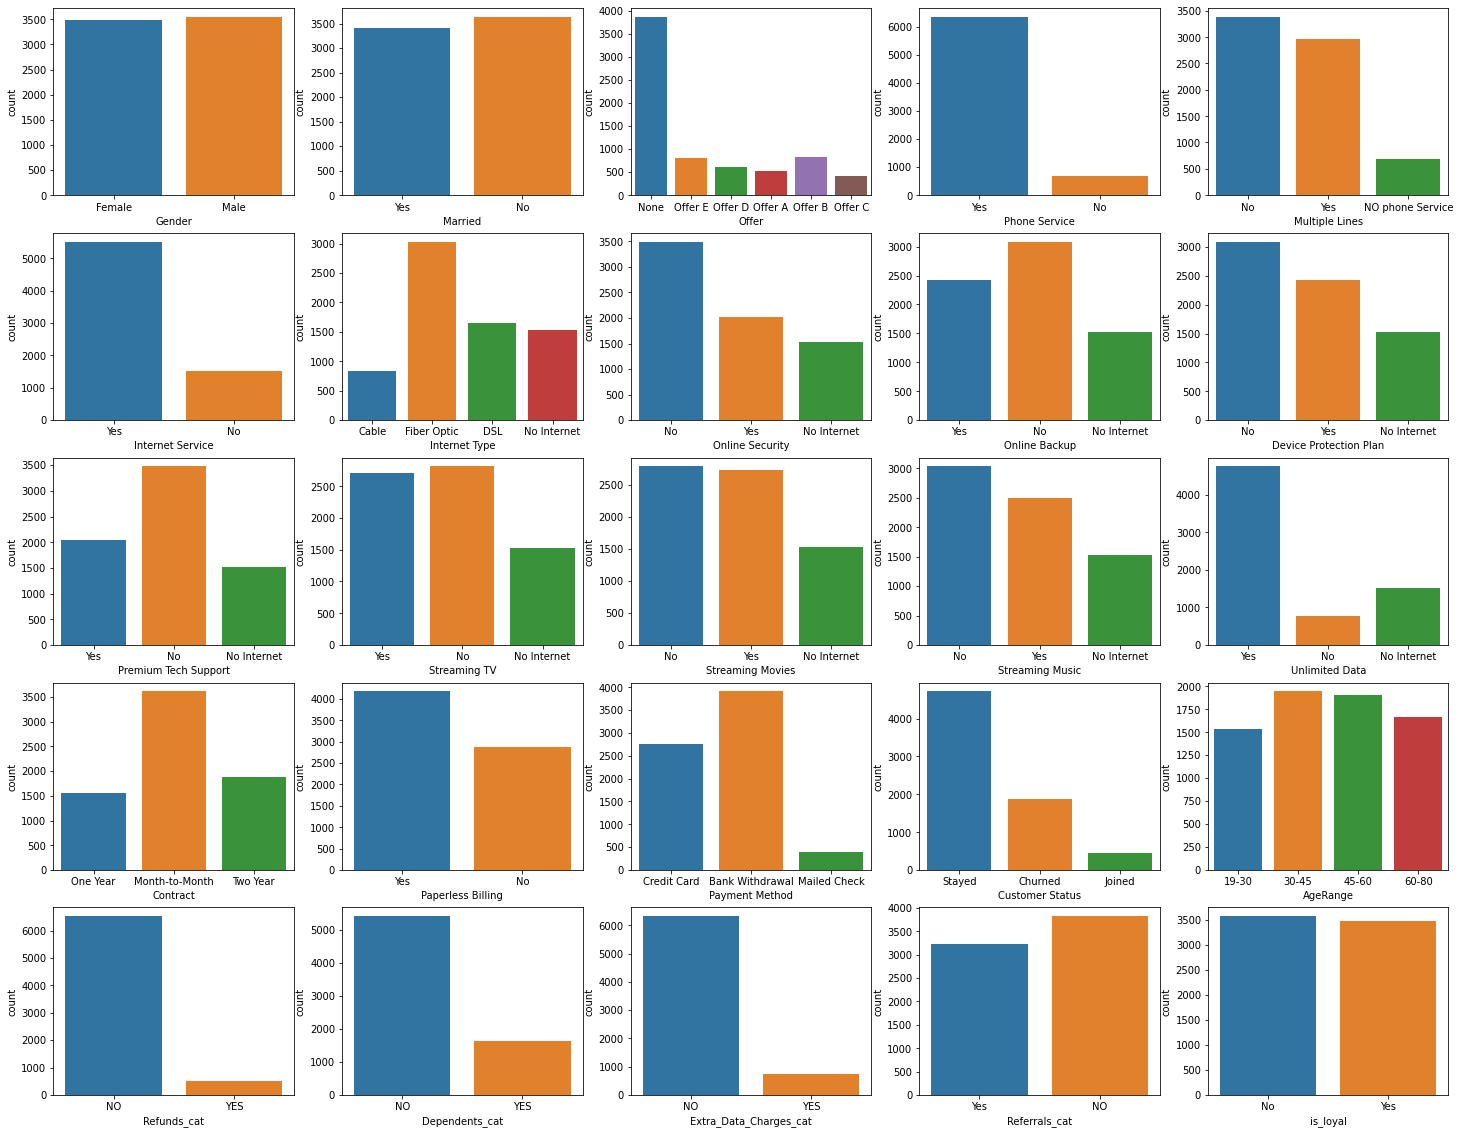

In [40]:
#Categorical
fig, axes = plt.subplots(5,5,figsize=(25,20))
for i,col in enumerate(df_object.columns):
    sns.countplot(data=df_object,x=col,ax=axes.flat[i])

#### 

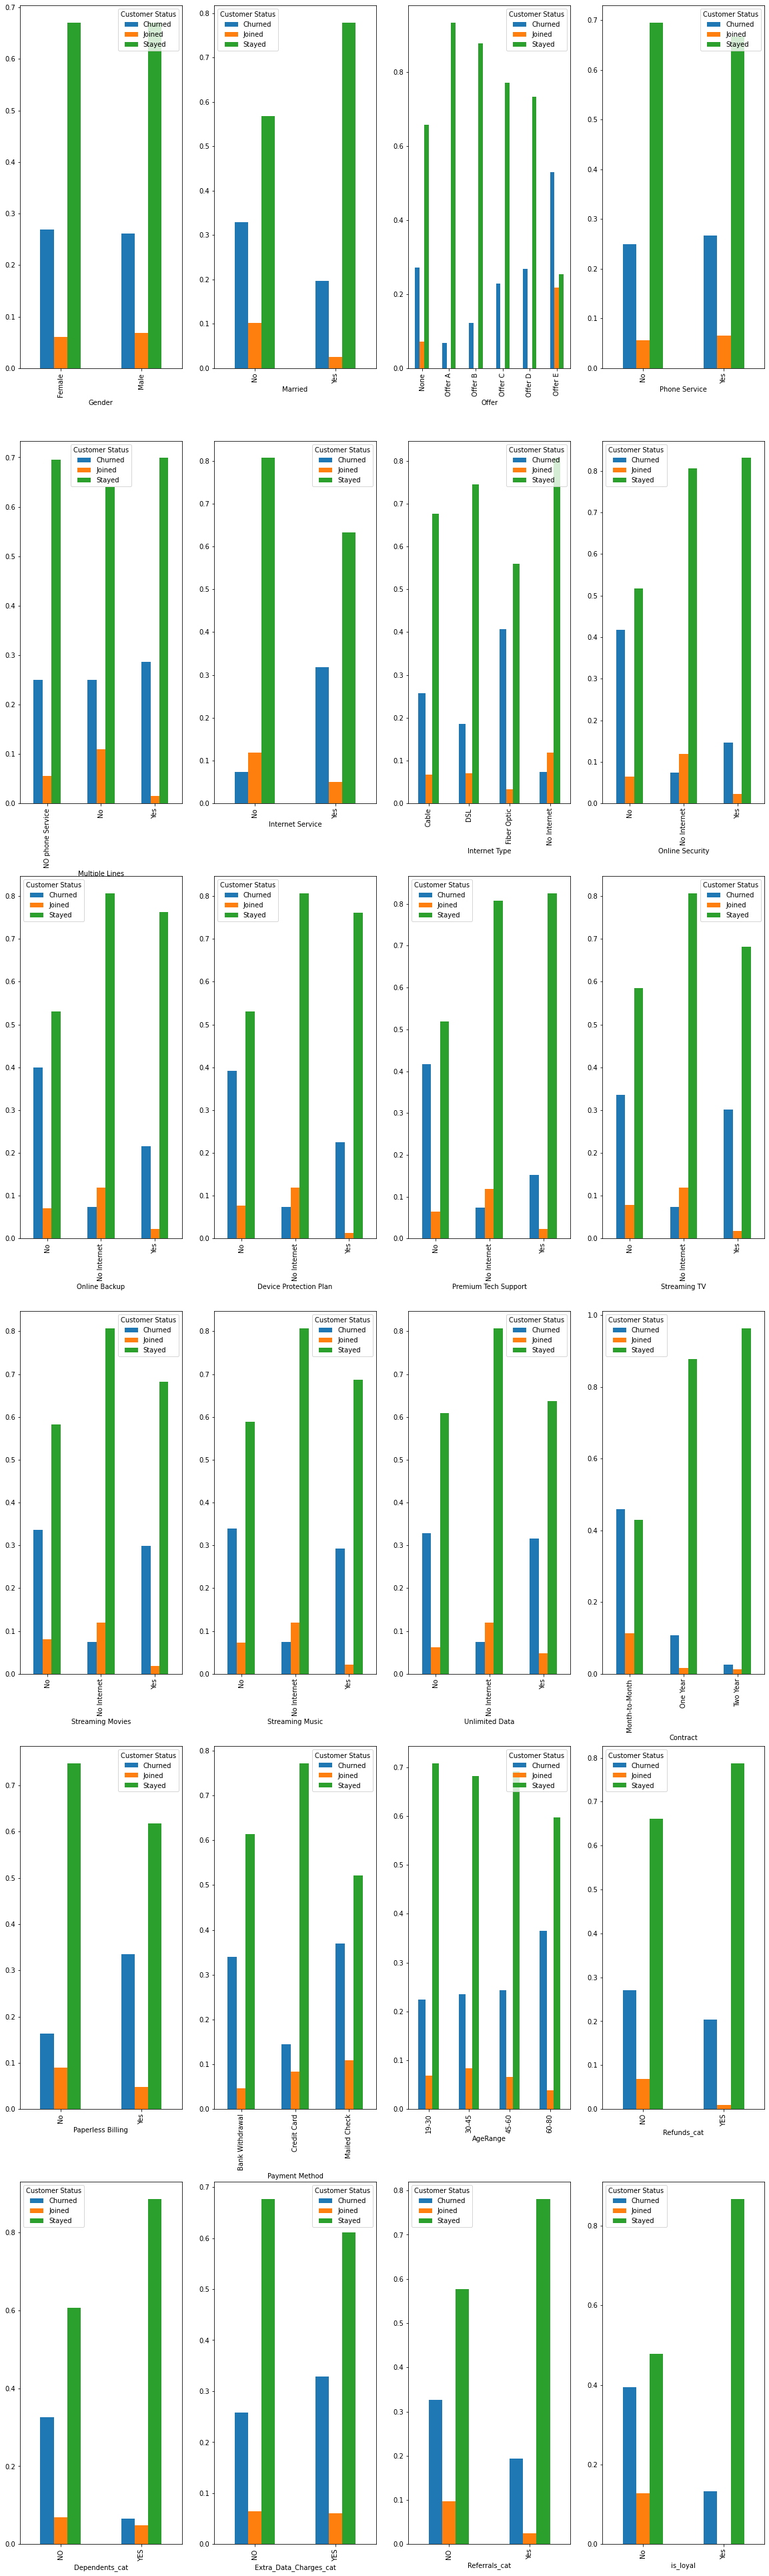

In [41]:
i=0
fig,axes=plt.subplots(6,4,figsize=(20,70))
for col in df_object.columns:
    if col != 'Customer Status':
        pd.crosstab(df_object[col],df_object['Customer Status'],normalize='index').plot(kind='bar',ax=axes.flat[i])
        i+=1

**According to the plots**:
- Married people tend to stay loyal to the company
- People subscribing the offer "E" are likely to churn
- People not having internet service are more likely to churn compared to people who do not have it
- People not having online security, online Backup, Device Protection Plan and Premium Tech Support are more likely to churn than people who have them
- People not having dependents living with them are more likely to churn compare to people who do have


#### Why People subscribed to offer E are more likely to churn?

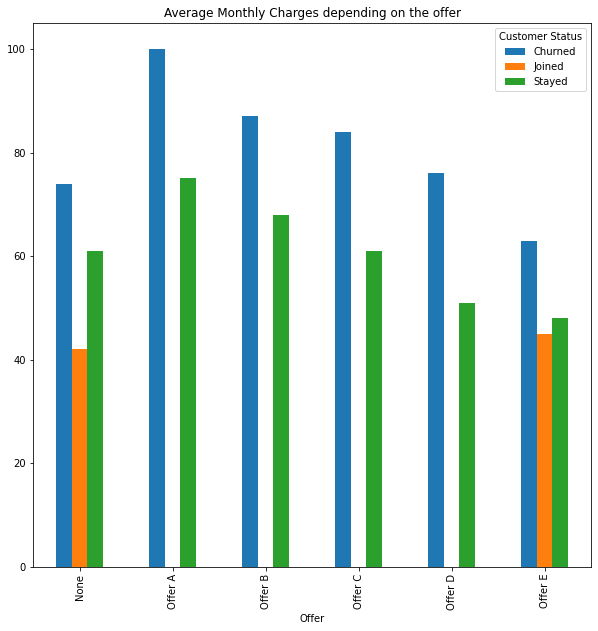

In [42]:
pd.crosstab(df['Offer'],df['Customer Status'],values=df['Monthly Charge'],aggfunc=np.mean).round(0).plot(kind='bar',title='Average Monthly Charges depending on the offer',figsize=(10,10));

People subscribing to offer E have the lowest monthly charges, therefore it's not about money. Probably it's about the quality of the offer

#### Let's analyze the distribution of the Customer Status based on the Monthly charge variable

In [43]:
df_num.describe()

,Age,Number of Dependents,Number of Referrals,Tenure in Months,Avg Monthly GB Download,Monthly Charge,Total Refunds,Total Extra Data Charges,Total Revenue
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,46.509726,0.468692,1.951867,32.386767,20.515405,63.596131,1.962182,6.860713,3034.379056
std,16.750352,0.962802,3.001199,24.542061,20.418940,31.204743,7.902614,25.104978,2865.204542
min,19.000000,0.000000,0.000000,1.000000,0.000000,-10.000000,0.000000,0.000000,21.360000
25%,32.000000,0.000000,0.000000,9.000000,3.000000,30.400000,0.000000,0.000000,605.610000
50%,46.000000,0.000000,0.000000,29.000000,17.000000,70.050000,0.000000,0.000000,2108.640000
75%,60.000000,0.000000,3.000000,55.000000,27.000000,89.750000,0.000000,0.000000,4801.145000
max,80.000000,9.000000,11.000000,72.000000,85.000000,118.750000,49.790000,150.000000,11979.340000


In [44]:
bins = [0,30,70,90,119]
names = ['0-30','30-70','70-90','90-119']
df_object['Charges'] = pd.cut(df['Monthly Charge'],bins, labels=names,include_lowest=True)

In [45]:
df_object.columns

Index(['Gender', 'Married', 'Offer', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract',
       'Paperless Billing', 'Payment Method', 'Customer Status', 'AgeRange',
       'Refunds_cat', 'Dependents_cat', 'Extra_Data_Charges_cat',
       'Referrals_cat', 'is_loyal', 'Charges'],
      dtype='object')

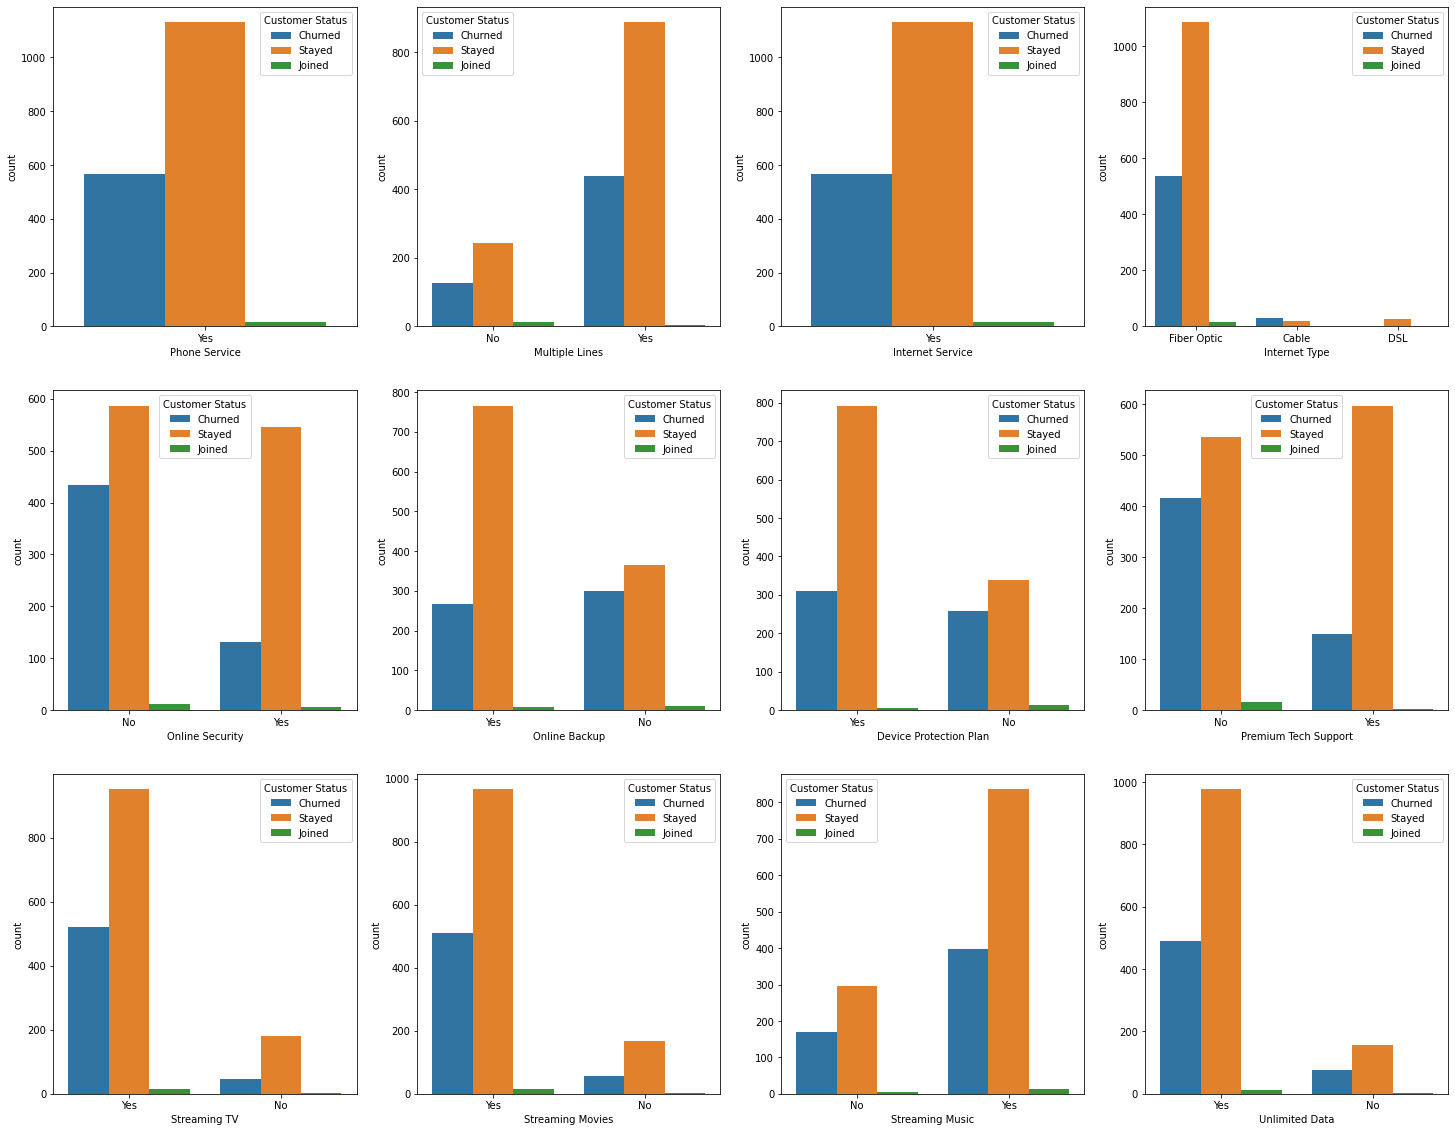

In [46]:
#Categorical

fig, axes = plt.subplots(3,4,figsize=(25,20))
for i,col in enumerate(['Phone Service','Multiple Lines','Internet Service','Internet Type','Online Security','Online Backup','Device Protection Plan','Premium Tech Support','Streaming TV','Streaming Movies','Streaming Music','Unlimited Data']):
    sns.countplot(data=df_object[df_object['Charges'] == '90-119'],x=col,ax=axes.flat[i],hue='Customer Status')


#### As expected people paying high monthly charges are more likely to churn if they do not have additional services (Online Security, Online Backup, Device Protection Plan, Premium Tech Support, Streaming TV etc ...) included in their plan. 

# Modeling 
---
## First Iteration: Logistic Regression
This section consists in training a Logistic Regression algorithm on the dataset poorly preprocessed to define a baseline

In [47]:
df = df.drop(['Zip Code','Latitude','Longitude','City'],axis=1)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Age                                7043 non-null   int64  
 2   Married                            7043 non-null   object 
 3   Number of Dependents               7043 non-null   int64  
 4   Number of Referrals                7043 non-null   int64  
 5   Tenure in Months                   7043 non-null   int64  
 6   Offer                              7043 non-null   object 
 7   Phone Service                      7043 non-null   object 
 8   Avg Monthly Long Distance Charges  6361 non-null   float64
 9   Multiple Lines                     6361 non-null   object 
 10  Internet Service                   7043 non-null   object 
 11  Internet Type                      5517 non-null   objec

In [49]:
# --- Replacing Nan values according to the EDA ---

df[['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 
           'Premium Tech Support', 'Streaming TV', 'Streaming Movies','Streaming Music','Unlimited Data']] = df[['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 
           'Premium Tech Support', 'Streaming TV', 'Streaming Movies','Streaming Music','Unlimited Data']].replace(np.nan,'No Internet')
df['Avg Monthly GB Download'] = df['Avg Monthly GB Download'].replace(np.nan,0.0)
df['Multiple Lines'] = df['Multiple Lines'].replace(np.nan,'NO phone Service')
df['Avg Monthly Long Distance Charges'] = df['Avg Monthly Long Distance Charges'].replace(np.nan,0.0)



In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             7043 non-null   object 
 1   Age                                7043 non-null   int64  
 2   Married                            7043 non-null   object 
 3   Number of Dependents               7043 non-null   int64  
 4   Number of Referrals                7043 non-null   int64  
 5   Tenure in Months                   7043 non-null   int64  
 6   Offer                              7043 non-null   object 
 7   Phone Service                      7043 non-null   object 
 8   Avg Monthly Long Distance Charges  7043 non-null   float64
 9   Multiple Lines                     7043 non-null   object 
 10  Internet Service                   7043 non-null   object 
 11  Internet Type                      7043 non-null   objec

In [51]:
df[df['Monthly Charge'] <= 0][['Monthly Charge','Total Revenue','Total Charges','Total Refunds','Total Extra Data Charges','Customer Status']]

,Monthly Charge,Total Revenue,Total Charges,Total Refunds,Total Extra Data Charges,Customer Status
1,-4.0,610.28,542.40,38.33,10,Stayed
32,-2.0,10830.97,7942.15,0.00,0,Stayed
170,-3.0,465.70,465.70,0.00,0,Stayed
232,-8.0,4669.60,4539.60,0.00,130,Stayed
336,-1.0,397.25,343.95,0.00,20,Churned
...,...,...,...,...,...,...
6894,-1.0,3301.73,2192.90,0.00,0,Stayed
6918,-7.0,8995.92,6860.60,44.00,0,Stayed
6976,-1.0,5620.45,3640.45,0.00,0,Churned
7020,-1.0,2907.77,2030.30,10.20,0,Churned


#### We assume that the negative values in the Monthly charge variable are erroneous. 

In [52]:
df = df[df['Monthly Charge'] >= 0]

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6923 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             6923 non-null   object 
 1   Age                                6923 non-null   int64  
 2   Married                            6923 non-null   object 
 3   Number of Dependents               6923 non-null   int64  
 4   Number of Referrals                6923 non-null   int64  
 5   Tenure in Months                   6923 non-null   int64  
 6   Offer                              6923 non-null   object 
 7   Phone Service                      6923 non-null   object 
 8   Avg Monthly Long Distance Charges  6923 non-null   float64
 9   Multiple Lines                     6923 non-null   object 
 10  Internet Service                   6923 non-null   object 
 11  Internet Type                      6923 non-null   objec

####  `Let's split our dataset into a train set and test set. We will keep the the proportion of the values of the target variable the same in both test and train set. This is important because the target variable is quite imbalanced`

In [54]:
# --- Data Set splitting ---
X = df.drop('Customer Status',axis=1)
y = df['Customer Status']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=321) 

In [55]:
pd.Series({c: df.select_dtypes('object')[c].unique() for c in df.select_dtypes('object')})


Gender                                                       [Female, Male]
Married                                                           [Yes, No]
Offer                     [None, Offer E, Offer D, Offer A, Offer B, Off...
Phone Service                                                     [Yes, No]
Multiple Lines                                  [No, Yes, NO phone Service]
Internet Service                                                  [Yes, No]
Internet Type                        [Cable, Fiber Optic, DSL, No Internet]
Online Security                                      [No, Yes, No Internet]
Online Backup                                        [Yes, No, No Internet]
Device Protection Plan                               [No, Yes, No Internet]
Premium Tech Support                                 [Yes, No, No Internet]
Streaming TV                                         [Yes, No, No Internet]
Streaming Movies                                     [No, Yes, No Internet]
Streaming Mu

#### Internet Type is an ordinal variable (fiber optic > cable > dsl) so we can encode it with Label encoder

In [56]:
#--- Label encoding the Ordinal Internet Type Variable ---
ord_encoder = LabelEncoder()
X_train['Internet Type'] = ord_encoder.fit_transform(X_train['Internet Type'])
X_test['Internet Type'] = ord_encoder.transform(X_test['Internet Type'])

In [57]:
#--- Standardizing numeric columns ---
num_col = X_train.select_dtypes('number').columns
std_scaler = StandardScaler()
X_train[num_col] = std_scaler.fit_transform(X_train[num_col])
X_test[num_col] = std_scaler.transform(X_test[num_col])

In [58]:
X_train[num_col]

,Age,Number of Dependents,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Internet Type,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue
697,1.945836,-0.488500,-0.321659,-0.092412,1.627270,0.279708,0.157671,1.212921,0.274618,-0.241366,-0.277954,0.815075,0.454107
2507,-1.402134,-0.488500,0.011365,0.762789,1.063328,0.279708,2.679213,1.546314,1.501491,-0.241366,-0.277954,1.479740,1.617386
1892,-1.461919,-0.488500,-0.654683,1.251475,-0.942232,0.279708,1.854863,1.159843,1.683878,-0.241366,-0.277954,-0.259110,1.250956
1789,-1.342349,-0.488500,-0.654683,-0.825441,0.494200,0.279708,1.272968,1.168136,-0.492906,-0.241366,-0.277954,-0.449145,-0.522646
3794,1.108843,2.612739,1.676487,1.332923,-0.216238,0.279708,0.254653,1.410303,2.082447,-0.241366,-0.277954,0.617459,1.822767
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,-1.103208,-0.488500,-0.321659,-0.377479,0.974523,0.279708,0.303144,1.158184,0.017945,-0.241366,-0.277954,0.146843,0.055421
4613,-1.521705,-0.488500,-0.654683,-1.069784,-1.485432,-1.874703,1.515424,-0.050989,-0.849889,-0.241366,0.108710,-0.880486,-0.927508
3480,0.032710,-0.488500,-0.654683,-0.581098,0.705516,-1.874703,-0.181768,-0.288180,-0.578026,-0.241366,0.882038,-0.164410,-0.495884
5408,-0.326001,-0.488500,0.344390,0.844237,0.922018,-1.874703,-0.812153,0.303967,0.675725,-0.241366,-0.277954,1.436309,0.952980


In [59]:
#--- one hot encoding non ordinal features ---
oh_col = X.select_dtypes('object').drop('Internet Type',axis=1).columns #object columns to be one hot encoded 

oh_encoder = OneHotEncoder(sparse=False)
OH_encoded_train_features = oh_encoder.fit_transform(X_train[oh_col])
OH_encoded_X_train = pd.DataFrame(data=OH_encoded_train_features,index=X_train[oh_col].index,columns=oh_encoder.get_feature_names(X_train[oh_col].columns))

OH_encoded_test_features = oh_encoder.transform(X_test[oh_col])
OH_encoded_X_test = pd.DataFrame(data=OH_encoded_test_features,index=X_test[oh_col].index,columns=oh_encoder.get_feature_names(X_test[oh_col].columns))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [60]:
X_train = pd.concat([X_train,OH_encoded_X_train],axis=1)
X_train = X_train.drop(X_train[oh_col],axis=1)
X_test = pd.concat([X_test,OH_encoded_X_test],axis=1)
X_test = X_test.drop(X_test[oh_col],axis=1)

In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5538 entries, 697 to 5514
Data columns (total 62 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 5538 non-null   float64
 1   Number of Dependents                5538 non-null   float64
 2   Number of Referrals                 5538 non-null   float64
 3   Tenure in Months                    5538 non-null   float64
 4   Avg Monthly Long Distance Charges   5538 non-null   float64
 5   Internet Type                       5538 non-null   float64
 6   Avg Monthly GB Download             5538 non-null   float64
 7   Monthly Charge                      5538 non-null   float64
 8   Total Charges                       5538 non-null   float64
 9   Total Refunds                       5538 non-null   float64
 10  Total Extra Data Charges            5538 non-null   float64
 11  Total Long Distance Charges         5538 

In [62]:
# --- dictionary for saving f1-scores of each model ----


f1_churned = {}
f1_stayed = {}
f1_joined = {}
precision_churned = {}
precision_stayed = {}
precision_joined = {}
recall_churned = {}
recall_stayed = {}
recall_joined = {}


In [63]:
#--- Baseline score for Logistic Regression ---
lgr = LogisticRegression(max_iter=1000)
lgr.fit(X_train,y_train)
y_pred = lgr.predict(X_test)
print(classification_report(y_test,y_pred))



              precision    recall  f1-score   support

     Churned       0.68      0.72      0.70       368
      Joined       0.68      0.67      0.67        90
      Stayed       0.91      0.89      0.90       927

    accuracy                           0.83      1385
   macro avg       0.76      0.76      0.76      1385
weighted avg       0.83      0.83      0.83      1385



In [64]:
f1_churned['LogReg'] = f1_score(y_test,y_pred,average=None).round(2)[0]
f1_joined['LogReg'] = f1_score(y_test,y_pred,average=None).round(2)[1]
f1_stayed['LogReg'] = f1_score(y_test,y_pred,average=None).round(2)[2]

precision_churned['LogReg'] = precision_score(y_test,y_pred,average=None).round(2)[0]
precision_joined['LogReg'] = precision_score(y_test,y_pred,average=None).round(2)[1]
precision_stayed['LogReg'] = precision_score(y_test,y_pred,average=None).round(2)[2]
recall_churned['LogReg'] = recall_score(y_test,y_pred,average=None).round(2)[0]
recall_joined['LogReg'] = recall_score(y_test,y_pred,average=None).round(2)[1]
recall_stayed['LogReg'] = recall_score(y_test,y_pred,average=None).round(2)[2]


#### Logistic regression applied on the cleaned dataset not augmented by feature engineering has provided an f1-score for the Churned (which is the one we are most interested in) category equal to 0.72

#### Learning curves

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

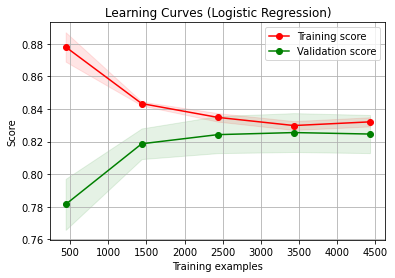

In [65]:
plot_learning_curve(lgr, "Learning Curves (Logistic Regression)", X_train, y_train, cv=5)

- The model doesn't overfit. As we can see, the curves converge and no gap between the training and the validation score exists 

#### Confusion Matrix

<AxesSubplot:xlabel='Predicted', ylabel='Real'>

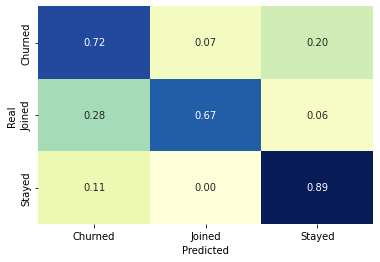

In [66]:
conf_matrix = pd.crosstab(y_test,y_pred,rownames=['Real'],colnames=['Predicted'],normalize='index')
sns.heatmap(conf_matrix,fmt='.2f',annot=True,cmap="YlGnBu", cbar=False)

- To note that 28% of the 'Joined' examples have been mispredicted as 'Churned' and just the 6% as 'Stayed', probably suggesting that the Tenure variable plays an important role in assigning the Customer Status

#### Let's try to remove all the examples having 'Joined' as Customer Status

In [67]:
joined_rows_train = y_train[y_train == 'Joined'].index
joined_rows_test = y_test[y_test == 'Joined'].index

y_train = y_train[y_train != 'Joined']
y_test = y_test[y_test != 'Joined']

In [68]:
X_train = X_train.drop(joined_rows_train,axis=0)
X_test = X_test.drop(joined_rows_test,axis=0)

In [69]:
lgr = LogisticRegression(max_iter=1000)
lgr.fit(X_train,y_train)
y_pred = lgr.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     Churned       0.74      0.77      0.75       368
      Stayed       0.91      0.89      0.90       927

    accuracy                           0.86      1295
   macro avg       0.82      0.83      0.83      1295
weighted avg       0.86      0.86      0.86      1295



#### As expected by removing the examples belonging to the minority class ('Joined') we gained about 5% in the f1-score associated to the 'Churned' class

## Feature Engineering
This section consists in augmenting our dataset by features engineered after EDA

#### Let's define a function to obtained the engineered dataset each time called

In [70]:
def eng_df():
    df_eng = df.copy()
    df_eng['AgeRange'] = pd.cut(df_eng['Age'],bins, labels=names,include_lowest=True).astype('object')
    df_eng['is_loyal'] = np.where(df_eng['Tenure in Months'] >= 30, 'Yes','No')
    df_eng['Refunds_cat'] = np.where(df_eng['Total Refunds'] == 0,'NO','YES')
    df_eng['Dependents_cat'] = np.where(df_eng['Number of Dependents'] == 0,'NO','YES')
    df_eng['Extra_Data_Charges_cat'] = np.where(df_eng['Total Extra Data Charges'] == 0,'NO','YES')
    df_eng['Referrals_cat'] = np.where(df_eng['Number of Referrals'] == 0, 'NO', 'Yes')
    return df_eng
    

In [71]:
df_eng = eng_df()

In [72]:
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6923 entries, 0 to 7042
Data columns (total 37 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             6923 non-null   object 
 1   Age                                6923 non-null   int64  
 2   Married                            6923 non-null   object 
 3   Number of Dependents               6923 non-null   int64  
 4   Number of Referrals                6923 non-null   int64  
 5   Tenure in Months                   6923 non-null   int64  
 6   Offer                              6923 non-null   object 
 7   Phone Service                      6923 non-null   object 
 8   Avg Monthly Long Distance Charges  6923 non-null   float64
 9   Multiple Lines                     6923 non-null   object 
 10  Internet Service                   6923 non-null   object 
 11  Internet Type                      6923 non-null   objec

In [73]:
# --- Data Set splitting ---
X = df_eng.drop('Customer Status',axis=1)
y = df_eng['Customer Status']
# y_trans = LabelEncoder()
# y_train = y_trans.fit_transform(y_train)
# y_test = y_trans.transform(y_test)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123) 

In [74]:
#--- Standardizing numeric columns ---
num_col = X_train.select_dtypes('number').columns
std_scaler = StandardScaler()
X_train[num_col] = std_scaler.fit_transform(X_train[num_col])
X_test[num_col] = std_scaler.transform(X_test[num_col])

In [75]:
#--- Label encoding the Ordinal Internet Type Variable ---
ord_encoder = OrdinalEncoder()
X_train[['Internet Type','AgeRange']] = ord_encoder.fit_transform(X_train[['Internet Type','AgeRange']])
X_test[['Internet Type','AgeRange']] = ord_encoder.transform(X_test[['Internet Type','AgeRange']])

In [76]:
X_train.describe()

,Age,Number of Dependents,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Internet Type,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,AgeRange
count,5.538000e+03,5.538000e+03,5.538000e+03,5.538000e+03,5.538000e+03,5538.000000,5.538000e+03,5.538000e+03,5.538000e+03,5.538000e+03,5.538000e+03,5.538000e+03,5.538000e+03,5538.000000
mean,-1.013595e-16,-1.154728e-17,-3.849094e-18,1.084161e-16,1.513977e-16,1.743590,-5.388731e-17,-2.562855e-16,-7.056672e-18,3.015124e-17,-3.849094e-17,9.494432e-17,-1.321522e-16,0.886421
std,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,0.926395,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,1.000090e+00,0.552721
min,-1.647754e+00,-4.843997e-01,-6.497468e-01,-1.279331e+00,-1.478011e+00,0.000000,-1.007761e+00,-1.553092e+00,-1.000461e+00,-2.451315e-01,-2.778971e-01,-8.822520e-01,-1.053010e+00,0.000000
25%,-8.132480e-01,-4.843997e-01,-6.497468e-01,-9.539050e-01,-8.958545e-01,1.000000,-8.481964e-01,-9.734342e-01,-8.354411e-01,-2.451315e-01,-2.778971e-01,-8.047945e-01,-8.493605e-01,1.000000
50%,-3.834989e-02,-4.843997e-01,-6.497468e-01,-1.403393e-01,-5.875928e-03,2.000000,-1.731154e-01,1.858824e-01,-3.918216e-01,-2.451315e-01,-2.778971e-01,-4.146104e-01,-3.253532e-01,1.000000
75%,7.961558e-01,-4.843997e-01,3.468275e-01,9.579743e-01,8.729940e-01,2.000000,3.178526e-01,8.334173e-01,6.792511e-01,-2.451315e-01,-2.778971e-01,5.276239e-01,6.289776e-01,1.000000
max,1.988307e+00,7.968080e+00,3.004359e+00,1.608827e+00,1.741238e+00,3.000000,3.165467e+00,1.791602e+00,2.823487e+00,6.061647e+00,5.615621e+00,3.306850e+00,3.051639e+00,2.000000


In [77]:
#--- one hot encoding non ordinal features ---
oh_col = X.select_dtypes('object').drop(['Internet Type','AgeRange'],axis=1).columns #object columns to be one hot encoded 

oh_encoder = OneHotEncoder(sparse=False)
OH_encoded_train_features = oh_encoder.fit_transform(X_train[oh_col])
OH_encoded_X_train = pd.DataFrame(data=OH_encoded_train_features,index=X_train[oh_col].index,columns=oh_encoder.get_feature_names(X_train[oh_col].columns))

OH_encoded_test_features = oh_encoder.transform(X_test[oh_col])
OH_encoded_X_test = pd.DataFrame(data=OH_encoded_test_features,index=X_test[oh_col].index,columns=oh_encoder.get_feature_names(X_test[oh_col].columns))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [78]:
X_train = pd.concat([X_train,OH_encoded_X_train],axis=1)
X_train = X_train.drop(X_train[oh_col],axis=1)
X_test = pd.concat([X_test,OH_encoded_X_test],axis=1)
X_test = X_test.drop(X_test[oh_col],axis=1)

In [79]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5538 entries, 5224 to 6805
Data columns (total 73 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 5538 non-null   float64
 1   Number of Dependents                5538 non-null   float64
 2   Number of Referrals                 5538 non-null   float64
 3   Tenure in Months                    5538 non-null   float64
 4   Avg Monthly Long Distance Charges   5538 non-null   float64
 5   Internet Type                       5538 non-null   float64
 6   Avg Monthly GB Download             5538 non-null   float64
 7   Monthly Charge                      5538 non-null   float64
 8   Total Charges                       5538 non-null   float64
 9   Total Refunds                       5538 non-null   float64
 10  Total Extra Data Charges            5538 non-null   float64
 11  Total Long Distance Charges         5538

## Logistic regression after feature engineering

In [80]:

lgr = LogisticRegression(max_iter=1000)
lgr.fit(X_train,y_train)
y_pred = lgr.predict(X_test)

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

     Churned       0.72      0.71      0.71       368
      Joined       0.71      0.72      0.72        90
      Stayed       0.91      0.91      0.91       927

    accuracy                           0.85      1385
   macro avg       0.78      0.78      0.78      1385
weighted avg       0.84      0.85      0.85      1385



#### As shown by the classification report, after feature engineering:
- the model precision towards the Churned class has increased of about 4% compared to the baseline model
- the model precision and recall towards the Joined class have increased of about 3 and 5% respectively compared to the baseline model
- the model recall towards the Stayed class has increased of about 2% compared to the baseline model

In [81]:
f1_churned['LogReg_ENG'] = f1_score(y_test,y_pred,average=None).round(2)[0]
f1_joined['LogReg_ENG'] = f1_score(y_test,y_pred,average=None).round(2)[1]
f1_stayed['LogReg_ENG'] = f1_score(y_test,y_pred,average=None).round(2)[2]

precision_churned['LogReg_ENG'] = precision_score(y_test,y_pred,average=None).round(2)[0]
precision_joined['LogReg_ENG'] = precision_score(y_test,y_pred,average=None).round(2)[1]
precision_stayed['LogReg_ENG'] = precision_score(y_test,y_pred,average=None).round(2)[2]
recall_churned['LogReg_ENG'] = recall_score(y_test,y_pred,average=None).round(2)[0]
recall_joined['LogReg_ENG'] = recall_score(y_test,y_pred,average=None).round(2)[1]
recall_stayed['LogReg_ENG'] = recall_score(y_test,y_pred,average=None).round(2)[2]


#### Model Performance:

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

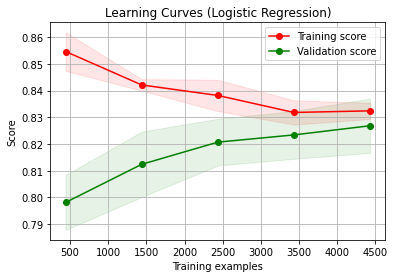

In [82]:
plot_learning_curve(lgr, "Learning Curves (Logistic Regression)", X_train, y_train, cv=5)

<AxesSubplot:xlabel='Predicted', ylabel='Real'>

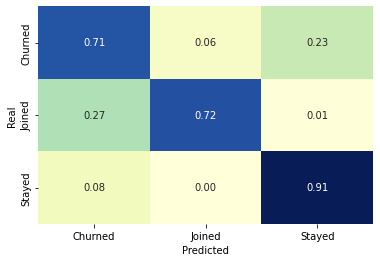

In [83]:
conf_matrix = pd.crosstab(y_test,y_pred,rownames=['Real'],colnames=['Predicted'],normalize='index')
sns.heatmap(conf_matrix,fmt='.2f',annot=True,cmap="YlGnBu", cbar=False)

# Handling Data Imbalance
---
we want to increase the recall of the churned category, because we are more interested in detecting people which are about to churn the company

In [84]:
df_smote = eng_df()

In [85]:
# --- Data Set splitting ---
X = df_smote.drop('Customer Status',axis=1)
y = df_smote['Customer Status']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123) 

#### Let's apply the smote tecnhique on the dataset where the 'Joined' category has been filtered out

In [86]:
joined_rows_train = y_train[y_train == 'Joined'].index
joined_rows_test = y_test[y_test == 'Joined'].index

y_train_sm = y_train[y_train != 'Joined']


In [87]:
X_train_sm = X_train.drop(joined_rows_train,axis=0)


In [88]:
from imblearn.over_sampling import SMOTENC

smote = SMOTENC(categorical_features=(X_train_sm.dtypes == "object").values,random_state=42)

X_train_sm, y_train_sm = smote.fit_resample(X_train_sm, y_train_sm)

In [89]:
y_train_sm.value_counts()

Stayed     3709
Churned    3709
Name: Customer Status, dtype: int64

In [90]:
X_train = pd.concat([X_train_sm,X_train.loc[joined_rows_train]])

In [91]:
y_train = pd.concat([y_train_sm,y_train[y_train == 'Joined']])

In [92]:
y_train.value_counts()

Stayed     3709
Churned    3709
Joined      358
Name: Customer Status, dtype: int64

In [93]:
#--- Standardizing numeric columns ---
num_col = X_train.select_dtypes('number').columns
std_scaler = StandardScaler()
X_train[num_col] = std_scaler.fit_transform(X_train[num_col])
X_test[num_col] = std_scaler.transform(X_test[num_col])

In [94]:
#--- Label encoding the Ordinal Internet Type Variable ---
ord_encoder = OrdinalEncoder()
X_train[['Internet Type','AgeRange']] = ord_encoder.fit_transform(X_train[['Internet Type','AgeRange']])
X_test[['Internet Type','AgeRange']] = ord_encoder.transform(X_test[['Internet Type','AgeRange']])

In [95]:
#--- one hot encoding non ordinal features ---
oh_col = X.select_dtypes('object').drop(['Internet Type','AgeRange'],axis=1).columns #object columns to be one hot encoded 

oh_encoder = OneHotEncoder(sparse=False)
OH_encoded_train_features = oh_encoder.fit_transform(X_train[oh_col])
OH_encoded_X_train = pd.DataFrame(data=OH_encoded_train_features,index=X_train[oh_col].index,columns=oh_encoder.get_feature_names(X_train[oh_col].columns))

OH_encoded_test_features = oh_encoder.transform(X_test[oh_col])
OH_encoded_X_test = pd.DataFrame(data=OH_encoded_test_features,index=X_test[oh_col].index,columns=oh_encoder.get_feature_names(X_test[oh_col].columns))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [96]:
X_train = pd.concat([X_train,OH_encoded_X_train],axis=1)
X_train = X_train.drop(X_train[oh_col],axis=1)
X_test = pd.concat([X_test,OH_encoded_X_test],axis=1)
X_test = X_test.drop(X_test[oh_col],axis=1)

In [97]:
lgr = LogisticRegression(max_iter=1000)
lgr.fit(X_train,y_train)
y_pred = lgr.predict(X_test)

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

     Churned       0.62      0.79      0.69       368
      Joined       0.72      0.49      0.58        90
      Stayed       0.93      0.85      0.89       927

    accuracy                           0.81      1385
   macro avg       0.75      0.71      0.72      1385
weighted avg       0.83      0.81      0.82      1385



#### As shown by the classification report, after feature engineering and SMOTE:
- the model precision towards the Churned class has decreased of about 6% compared to the baseline model
- the model recall towards the Churned class has increased of about 7% compared to the baseline model
- the model precision and towards the Joined class has increased of about 4% compared to the baseline model
- the model recall towards the Joined class has decreased of about **18%** compared to the baseline model
- the model precision towards the Stayed class has increased increased of about 2% compared to the baseline model
- the model recall towards the Stayed class has decreased of about 4% compared to the baselined model

In [98]:
f1_churned['LogReg_smote'] = f1_score(y_test,y_pred,average=None).round(2)[0]
f1_joined['LogReg_smote'] = f1_score(y_test,y_pred,average=None).round(2)[1]
f1_stayed['LogReg_smote'] = f1_score(y_test,y_pred,average=None).round(2)[2]

precision_churned['LogReg_smote'] = precision_score(y_test,y_pred,average=None).round(2)[0]
precision_joined['LogReg_smote'] = precision_score(y_test,y_pred,average=None).round(2)[1]
precision_stayed['LogReg_smote'] = precision_score(y_test,y_pred,average=None).round(2)[2]
recall_churned['LogReg_smote'] = recall_score(y_test,y_pred,average=None).round(2)[0]
recall_joined['LogReg_smote'] = recall_score(y_test,y_pred,average=None).round(2)[1]
recall_stayed['LogReg_smote'] = recall_score(y_test,y_pred,average=None).round(2)[2]


#### Model Performance:

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

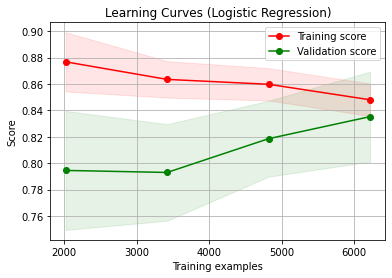

In [99]:
plot_learning_curve(lgr, "Learning Curves (Logistic Regression)", X_train, y_train, cv=5)

<AxesSubplot:xlabel='Predicted', ylabel='Real'>

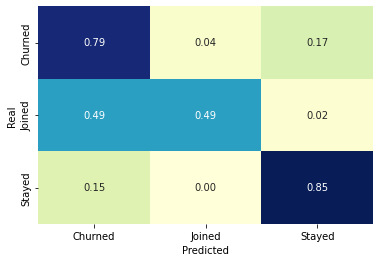

In [100]:
conf_matrix = pd.crosstab(y_test,y_pred,rownames=['Real'],colnames=['Predicted'],normalize='index')
sns.heatmap(conf_matrix,fmt='.2f',annot=True,cmap="YlGnBu", cbar=False)

# Testing other models
---
## SVC

In [101]:
df_svc = eng_df()

In [102]:
# --- Data Set splitting ---
X = df_svc.drop('Customer Status',axis=1)
y = df_svc['Customer Status']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123) 

In [103]:
#--- Standardizing numeric columns ---
num_col = X_train.select_dtypes('number').columns
std_scaler = StandardScaler()
X_train[num_col] = std_scaler.fit_transform(X_train[num_col])
X_test[num_col] = std_scaler.transform(X_test[num_col])

In [104]:
#--- Label encoding the Ordinal Internet Type Variable ---
ord_encoder = OrdinalEncoder()
X_train[['Internet Type','AgeRange']] = ord_encoder.fit_transform(X_train[['Internet Type','AgeRange']])
X_test[['Internet Type','AgeRange']] = ord_encoder.transform(X_test[['Internet Type','AgeRange']])

In [105]:
#--- one hot encoding non ordinal features ---
oh_col = X.select_dtypes('object').drop(['Internet Type','AgeRange'],axis=1).columns #object columns to be one hot encoded 

oh_encoder = OneHotEncoder(sparse=False)
OH_encoded_train_features = oh_encoder.fit_transform(X_train[oh_col])
OH_encoded_X_train = pd.DataFrame(data=OH_encoded_train_features,index=X_train[oh_col].index,columns=oh_encoder.get_feature_names(X_train[oh_col].columns))

OH_encoded_test_features = oh_encoder.transform(X_test[oh_col])
OH_encoded_X_test = pd.DataFrame(data=OH_encoded_test_features,index=X_test[oh_col].index,columns=oh_encoder.get_feature_names(X_test[oh_col].columns))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [106]:
X_train = pd.concat([X_train,OH_encoded_X_train],axis=1)
X_train = X_train.drop(X_train[oh_col],axis=1)
X_test = pd.concat([X_test,OH_encoded_X_test],axis=1)
X_test = X_test.drop(X_test[oh_col],axis=1)

In [107]:

clf = SVC(gamma="scale")
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

     Churned       0.71      0.70      0.70       368
      Joined       0.57      0.36      0.44        90
      Stayed       0.88      0.92      0.90       927

    accuracy                           0.83      1385
   macro avg       0.72      0.66      0.68      1385
weighted avg       0.82      0.83      0.82      1385



#### As shown by the classification report, the SVC model has provided the following results:
- the model precision towards the Churned class has increased of about 3% compared to the baseline model
- the model recall towards the Churned class has decreased of about 2% compared to the baseline model
- the model precision and recall towards the Joined class have decreased of about **11** and **31%** compared to the baseline model
- the model precision towards the Stayed class has decreased of about 3% compared to the baseline model
- the model recall towards the Stayed class has increased of about 3% compared to the baselined model

#### The SVC model while providing the same performances of the logistic regression in terms of precision and recall for Churned and Stayed classes, it poorly performs at predicting the Joined category

In [108]:
f1_churned['SVC'] = f1_score(y_test,y_pred,average=None).round(2)[0]
f1_joined['SVC'] = f1_score(y_test,y_pred,average=None).round(2)[1]
f1_stayed['SVC'] = f1_score(y_test,y_pred,average=None).round(2)[2]

precision_churned['SVC'] = precision_score(y_test,y_pred,average=None).round(2)[0]
precision_joined['SVC'] = precision_score(y_test,y_pred,average=None).round(2)[1]
precision_stayed['SVC'] = precision_score(y_test,y_pred,average=None).round(2)[2]
recall_churned['SVC'] = recall_score(y_test,y_pred,average=None).round(2)[0]
recall_joined['SVC'] = recall_score(y_test,y_pred,average=None).round(2)[1]
recall_stayed['SVC'] = recall_score(y_test,y_pred,average=None).round(2)[2]


#### Model Performance:

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

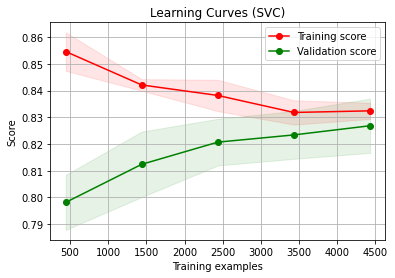

In [109]:
plot_learning_curve(lgr, "Learning Curves (SVC)", X_train, y_train, cv=5)

<AxesSubplot:xlabel='Predicted', ylabel='Real'>

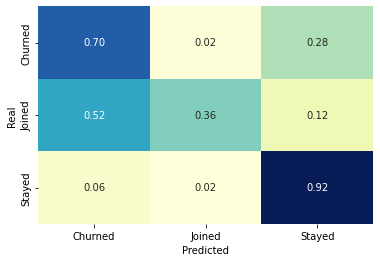

In [110]:
conf_matrix = pd.crosstab(y_test,y_pred,rownames=['Real'],colnames=['Predicted'],normalize='index')
sns.heatmap(conf_matrix,fmt='.2f',annot=True,cmap="YlGnBu", cbar=False)

#### As shown by the confusion matrix, 52 percent of the examples belonging to the 'Joined' class have been misclassified as 'Churned' by our model

## Random Forest

In [111]:
df_rf = eng_df()

In [112]:
# --- Data Set splitting ---
X = df_rf.drop('Customer Status',axis=1)
y = df_rf['Customer Status']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123) 

In [113]:
#--- Label encoding the Ordinal Internet Type Variable ---
ord_encoder = OrdinalEncoder()
X_train[['Internet Type','AgeRange']] = ord_encoder.fit_transform(X_train[['Internet Type','AgeRange']])
X_test[['Internet Type','AgeRange']] = ord_encoder.transform(X_test[['Internet Type','AgeRange']])

In [114]:
#--- one hot encoding non ordinal features ---
oh_col = X.select_dtypes('object').drop(['Internet Type','AgeRange'],axis=1).columns #object columns to be one hot encoded 

oh_encoder = OneHotEncoder(sparse=False)
OH_encoded_train_features = oh_encoder.fit_transform(X_train[oh_col])
OH_encoded_X_train = pd.DataFrame(data=OH_encoded_train_features,index=X_train[oh_col].index,columns=oh_encoder.get_feature_names(X_train[oh_col].columns))

OH_encoded_test_features = oh_encoder.transform(X_test[oh_col])
OH_encoded_X_test = pd.DataFrame(data=OH_encoded_test_features,index=X_test[oh_col].index,columns=oh_encoder.get_feature_names(X_test[oh_col].columns))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [115]:
X_train = pd.concat([X_train,OH_encoded_X_train],axis=1)
X_train = X_train.drop(X_train[oh_col],axis=1)
X_test = pd.concat([X_test,OH_encoded_X_test],axis=1)
X_test = X_test.drop(X_test[oh_col],axis=1)

In [116]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

     Churned       0.76      0.63      0.69       368
      Joined       0.81      0.67      0.73        90
      Stayed       0.88      0.95      0.91       927

    accuracy                           0.85      1385
   macro avg       0.82      0.75      0.78      1385
weighted avg       0.84      0.85      0.84      1385



#### As shown by the classification report, the Random Forest model has provided the following results:
- the model precision towards the Churned class has increased of about 7% compared to the baseline model
- the model recall towards the Churned class has decreased of about 8% compared to the baseline model
- the model precision towards the Joined class have increased of about **14%** compared to the baseline model
- the model precision towards the Stayed class has decreased of about 3% compared to the baseline model
- the model recall towards the Stayed class has increased of about 6% compared to the baselined model

In [117]:
f1_churned['Rf'] = f1_score(y_test,y_pred,average=None).round(2)[0]
f1_joined['Rf'] = f1_score(y_test,y_pred,average=None).round(2)[1]
f1_stayed['Rf'] = f1_score(y_test,y_pred,average=None).round(2)[2]

precision_churned['Rf'] = precision_score(y_test,y_pred,average=None).round(2)[0]
precision_joined['Rf'] = precision_score(y_test,y_pred,average=None).round(2)[1]
precision_stayed['Rf'] = precision_score(y_test,y_pred,average=None).round(2)[2]
recall_churned['Rf'] = recall_score(y_test,y_pred,average=None).round(2)[0]
recall_joined['Rf'] = recall_score(y_test,y_pred,average=None).round(2)[1]
recall_stayed['Rf'] = recall_score(y_test,y_pred,average=None).round(2)[2]


#### Model Performance:

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


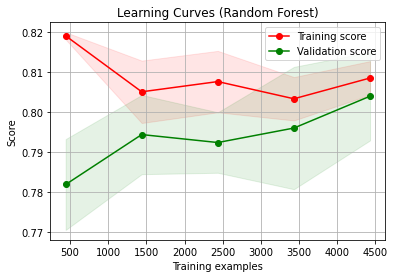

In [118]:
plot_learning_curve(lgr, "Learning Curves (Random Forest)", X_train, y_train, cv=5);

<AxesSubplot:xlabel='Predicted', ylabel='Real'>

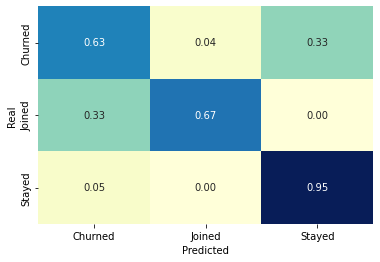

In [119]:
conf_matrix = pd.crosstab(y_test,y_pred,rownames=['Real'],colnames=['Predicted'],normalize='index')
sns.heatmap(conf_matrix,fmt='.2f',annot=True,cmap="YlGnBu", cbar=False)

- Verificare l'overfitting di tutti i modelli confrontando i valori delle accuracy sui test set e train set
- implementare la fase di EDA con corso ml.ai

## Gradient Boosting

In [120]:
df_gb = eng_df()

In [121]:
# --- Data Set splitting ---
X = df_gb.drop('Customer Status',axis=1)
y = df_gb['Customer Status']
# y_trans = LabelEncoder()
# y_train = y_trans.fit_transform(y_train)
# y_test = y_trans.transform(y_test)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123) 

In [122]:
#--- Standardizing numeric columns ---
num_col = X_train.select_dtypes('number').columns
std_scaler = StandardScaler()
X_train[num_col] = std_scaler.fit_transform(X_train[num_col])
X_test[num_col] = std_scaler.transform(X_test[num_col])

In [123]:
#--- Label encoding the Ordinal Internet Type Variable ---
ord_encoder = OrdinalEncoder()
X_train[['Internet Type','AgeRange']] = ord_encoder.fit_transform(X_train[['Internet Type','AgeRange']])
X_test[['Internet Type','AgeRange']] = ord_encoder.transform(X_test[['Internet Type','AgeRange']])

In [124]:
#--- one hot encoding non ordinal features ---
oh_col = X.select_dtypes('object').drop(['Internet Type','AgeRange'],axis=1).columns #object columns to be one hot encoded 

oh_encoder = OneHotEncoder(sparse=False)
OH_encoded_train_features = oh_encoder.fit_transform(X_train[oh_col])
OH_encoded_X_train = pd.DataFrame(data=OH_encoded_train_features,index=X_train[oh_col].index,columns=oh_encoder.get_feature_names(X_train[oh_col].columns))

OH_encoded_test_features = oh_encoder.transform(X_test[oh_col])
OH_encoded_X_test = pd.DataFrame(data=OH_encoded_test_features,index=X_test[oh_col].index,columns=oh_encoder.get_feature_names(X_test[oh_col].columns))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [125]:
X_train = pd.concat([X_train,OH_encoded_X_train],axis=1)
X_train = X_train.drop(X_train[oh_col],axis=1)
X_test = pd.concat([X_test,OH_encoded_X_test],axis=1)
X_test = X_test.drop(X_test[oh_col],axis=1)

In [126]:
xg = GradientBoostingClassifier(learning_rate=0.01, n_estimators=400,max_depth=13)
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

     Churned       0.75      0.68      0.71       368
      Joined       0.76      0.66      0.70        90
      Stayed       0.90      0.94      0.92       927

    accuracy                           0.85      1385
   macro avg       0.80      0.76      0.78      1385
weighted avg       0.85      0.85      0.85      1385



In [127]:
f1_churned['GB'] = f1_score(y_test,y_pred,average=None).round(2)[0]
f1_joined['GB'] = f1_score(y_test,y_pred,average=None).round(2)[1]
f1_stayed['GB'] = f1_score(y_test,y_pred,average=None).round(2)[2]

precision_churned['GB'] = precision_score(y_test,y_pred,average=None).round(2)[0]
precision_joined['GB'] = precision_score(y_test,y_pred,average=None).round(2)[1]
precision_stayed['GB'] = precision_score(y_test,y_pred,average=None).round(2)[2]
recall_churned['GB'] = recall_score(y_test,y_pred,average=None).round(2)[0]
recall_joined['GB'] = recall_score(y_test,y_pred,average=None).round(2)[1]
recall_stayed['GB'] = recall_score(y_test,y_pred,average=None).round(2)[2]


#### As shown by the classification report, the Random Forest model has provided the following results:
- the model precision towards the Churned class has increased of about 7% compared to the baseline model
- the model recall towards the Churned class has decreased of about 4% compared to the baseline model
- the model precision and recall towards the Joined class have increased of about **9%** and 1% compared to the baseline model
- the model precision towards the Stayed class has decreased of about 1% compared to the baseline model
- the model recall towards the Stayed class has increased of about 5% compared to the baselined model

#### Model Performance:

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

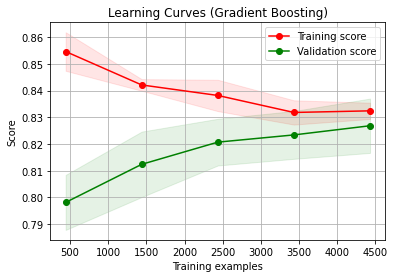

In [128]:
plot_learning_curve(lgr, "Learning Curves (Gradient Boosting)", X_train, y_train, cv=5)

<AxesSubplot:xlabel='Predicted', ylabel='Real'>

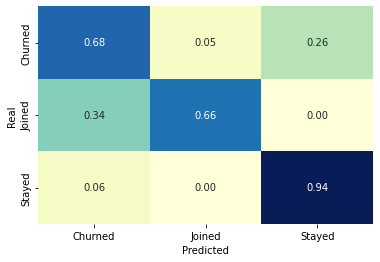

In [129]:
conf_matrix = pd.crosstab(y_test,y_pred,rownames=['Real'],colnames=['Predicted'],normalize='index')
sns.heatmap(conf_matrix,fmt='.2f',annot=True,cmap="YlGnBu", cbar=False)

# Model Comparison and Final remarks

In [130]:
f1 = pd.DataFrame.from_dict({'churned':f1_churned,'joined':f1_joined,'stayed':f1_stayed})
precision = pd.DataFrame.from_dict({'churned':precision_churned,'joined':precision_joined,'stayed':precision_stayed})
recall = pd.DataFrame.from_dict({'churned':recall_churned,'joined':recall_joined,'stayed':recall_stayed})

Maximum scores


,model,f1,model,precision,model,recall
churned,LogReg_ENG,0.71,Rf,0.76,LogReg_smote,0.79
joined,Rf,0.73,Rf,0.81,LogReg_ENG,0.72
stayed,GB,0.92,LogReg_smote,0.93,Rf,0.95


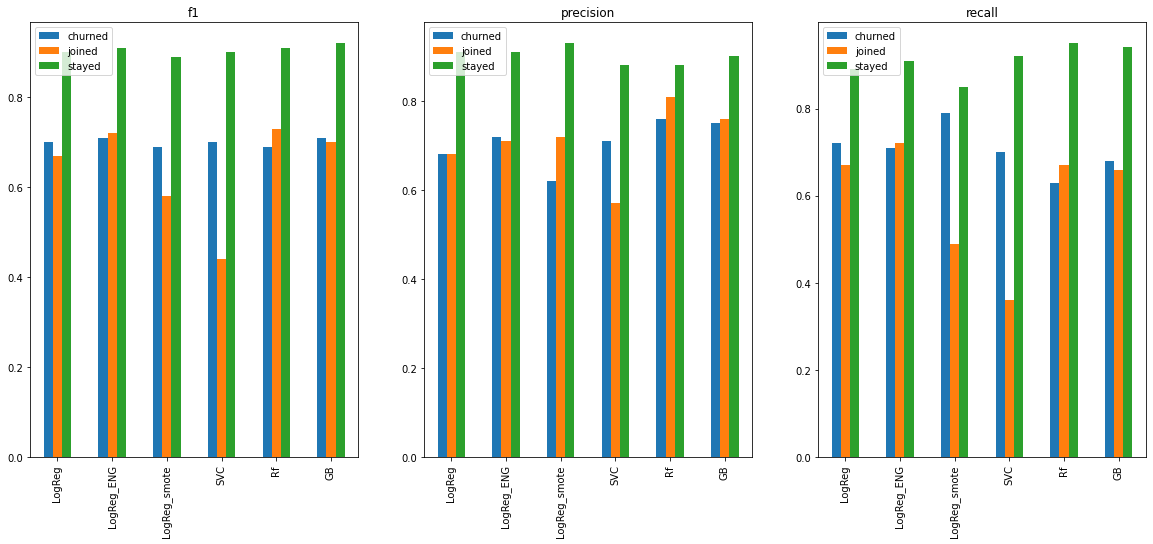

In [131]:
fig,axes = plt.subplots(1,3,figsize=(20,8))

#f1 plot
axes.flat[0].set_title('f1')
f1.plot.bar(ax=axes.flat[0]);
#precision plot
axes.flat[1].set_title('precision')
precision.plot.bar(ax=axes.flat[1]);
#recall plot
axes.flat[2].set_title('recall')
recall.plot.bar(ax=axes.flat[2]);

print('Maximum scores')
pd.concat([f1.idxmax().rename('model'),f1.max().rename('f1'),precision.idxmax().rename('model'),precision.max().rename('precision'),recall.idxmax().rename('model'),recall.max().rename('recall')],axis=1)



#### From the above plot we can deduce:
1. The maximum f1 score for churned category is given by the logistic regression model augmented with artificial features (0.71), neverthless on averaged all the models show similar performances.
2. The maximum precision score for churned class is given by the random forest classifier (0.75) which showed quite high precision (0.85) for the minority class (joined) as well
3. The maximum recall score for churned class is given by the logistic regression model on the oversampled (SMOTE) dataset, neverthless the recall score for the joined category is very low (0.49)

As final remark, I'd like to stress that the inclusion of new artificial features has improved the overall performance of the logistic regression model. In particular the precision score for the prediction of the churned class has increased of 4% compared to the baseline model. 